# **Цель проекта**

Создать классификатор, основанный на интерпретируемых лингвистических признаках, способный отличать хорошую качественную прозу от массовой.

Проект состоит из четырёх частей:
- сбор корпуса русской прозы разных веков;
- анализ русской классики XVIII–XX веков, помогающий определить устойчивые метрики "литературности" — такие как средняя длина предложения, доля различных частей речи, количество абстрактной и жаргонной лексики и т.д.;
- сравнение различных текстов XXI века с классикой, количественное описание признаков современной "качественной" прозы;
- создание классификатора, который позволяет по отрывку текста определить его принадлежность к качественной или массовой литературе.

**Импорты**

In [1]:
!pip install natasha
!pip install -U spacy
!python -m spacy download ru_core_news_md
!pip install stanza

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 79.2 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=bda39396886f7ec9eea67a4136c8de2d2d30fdc8b22faa9dd1ecab385848fa0e
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26098 sha256=7ab8b1baab67680e70a6eaf5e6fcf6152069dd7b547caea7c800a73e62df13ca
  Stored in directory: /root/.cache/pip/wheels/31/d7/d9/eec6891f78cac19a693bd40ecb8365d2f4613318c145ec9816
Successfully built docopt intervaltree
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import re
from google.colab import files
import nltk
from nltk import pos_tag
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
russian_stopwords = set(stopwords.words("russian"))
import numpy as np
from collections import defaultdict
import spacy
from tqdm import tqdm
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display, clear_output
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal, pearsonr, zscore
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

from natasha import (
    Segmenter,
    MorphVocab,
    NewsEmbedding,
    NewsMorphTagger,
    Doc
)

import pymorphy3

import stanza
stanza.download('ru')
stanza_nlp = stanza.Pipeline('ru')
import openpyxl
import joblib

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: ru (Russian) ...


INFO:stanza:Downloaded file to /root/stanza_resources/ru/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: ru (Russian):
| Processor | Package            |
----------------------------------
| tokenize  | syntagrus          |
| pos       | syntagrus_charlm   |
| lemma     | syntagrus_nocharlm |
| depparse  | syntagrus_charlm   |
| ner       | wikiner            |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


In [3]:
import sys
sys.path.append('/content/python-ruwordnet')


In [4]:
!git clone https://github.com/avidale/python-ruwordnet.git

!wget https://github.com/avidale/python-ruwordnet/releases/download/0.0.4/ruwordnet-2021.db -O ruwordnet/static/ruwordnet.db

%cd python-ruwordnet
!pip install .

from ruwordnet import RuWordNet

wn = RuWordNet()


Cloning into 'python-ruwordnet'...
remote: Enumerating objects: 153, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 153 (delta 35), reused 53 (delta 21), pack-reused 71 (from 1)
Receiving objects: 100% (153/153), 116.48 MiB | 12.96 MiB/s, done.
Resolving deltas: 100% (63/63), done.
Updating files: 100% (41/41), done.
ruwordnet/static/ruwordnet.db: No such file or directory
/content/python-ruwordnet
Processing /content/python-ruwordnet
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.0 MB/s eta 0:00:00
  Created wheel for ruwordnet: filename=ruwordnet-0.0.6-py3-none-any.whl size=13580 sha256=3407947fec5f3308bb93790d255763471ea8ab2283aeffb18c96e1a81202d440
  Stored in directory: /root/.cache/pip/wheels/ac/16/dd/24ad659d96ed57c8256c0dd29ae12cb5f9d805d6e28eed57af
Successfully built ruwordnet
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.

### **Сбор корпуса текстов**

Для работы необходимо собрать корпус текстов русской литературы с XVIII по XXI век.
Структура по векам:
1.	XVIII век — Радищев, Карамзин, Фонвизин, Крылов (проза), а также письма некоторых поэтов.
2.	XIX век — Гоголь, Достоевский, Тургенев, Гончаров, Лесков, Лермонтов, Пушкин, Толстой, Чехов.
3.	XX век — Булгаков, Бунин, Горький, Куприн, Замятин, Набоков, Довлатов, Зощенко, Шолохов и др.
4. XXI век - Яхина, Пелевин, Прилепин, Водолазкин, Быков, Улицкая, Рубина, Абгарян, Данцова, Маринина, Глуховский и др.


***Этот этап вынесен в отдельную тетрадку.***

### **Анализ** **текстов**

Загружаем необходимые файлы:
- датафрейм с текстами;
- словарь устаревших слов;
- толковый словарь Ожегова.

In [5]:
uploaded = files.upload()


Saving archaic_lemmas.txt to archaic_lemmas.txt
Saving cleaned_texts_excel.xlsx to cleaned_texts_excel.xlsx
Saving df_dict.csv to df_dict.csv
Saving Ожегов Сергей. Толковый словарь русского языка - royallib.ru.txt to Ожегов Сергей. Толковый словарь русского языка - royallib.ru.txt


In [7]:
df_texts = pd.read_excel("cleaned_texts_excel.xlsx")
df_texts.head()

,author,title,url,century,cat,text
0,И.Ф.Богданович,"Письмо Н.И.Панину, 1 декабря 1767",https://rvb.ru/18vek/letters_rus_writers/01tex...,18,class,"Милостивый государь, сиятельнейший граф. Намер..."
1,Н.М.Карамзин,"Марфа-Посадница, или покорение Новагорода",https://rvb.ru/18vek/karamzin/2hudlit/01text/v...,18,class,Вот один из самых важнейших случаев российской...
2,Н.М. Карамзин,Бедная Лиза,https://rvb.ru/18vek/karamzin/2hudlit/01text/v...,18,class,"Может быть, никто из живущих в Москве не знает..."
3,Н.М.Карамзин,Чувствительный и холодный,https://rvb.ru/18vek/karamzin/2hudlit/01text/v...,18,class,Дух системы заставлял разумных людей утверждат...
4,Н.М.Карамзин,Рыцарь нашего времени,https://rvb.ru/18vek/karamzin/2hudlit/01text/v...,18,class,С некоторого времени вошли в модуисторические ...


Предобработка текста, деление на токены, леммы и на значимые леммы (только самостоятельные части речи)

In [8]:
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

custom_stopwords = set(stopwords.words("russian")) | {
    'сказать', 'говорить', 'стать', 'то', 'становиться', 'очень', 'сразу', 'потом',
    'идти', 'мочь', 'стоять', 'лежать', 'сидеть', 'думать', 'смотреть', 'видеть',
    'знать', 'хотеть', 'пойти', 'делать', 'брать', 'давать', 'начать', 'оказаться',
    'подойти', 'произнести', 'ответить', 'услышать', 'показаться', 'спросить',
    'заметить', 'продолжать', 'вернуться', 'посмотреть', 'почувствовать', 'встать',
    'подняться', 'остаться', 'последовать', 'выйти', 'действительно', 'казаться',
    'сделать', 'пойти', 'нужно', 'происходить'
}

# функция для предобработки текстов

def process_text(text):
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)

    tokens = [_.text for _ in doc.tokens if _.text.strip()]  # все токены
    lemmas = []  # все леммы
    content_lemmas = []  # только значимые леммы

    for token in doc.tokens:
        token.lemmatize(morph_vocab)
        lemma = token.lemma.lower()
        lemmas.append(lemma)

        if (
            token.pos in {'NOUN', 'VERB', 'ADJ', 'ADV'} and
            lemma not in custom_stopwords and
            re.match(r'^[а-яА-ЯёЁ\-]+$', lemma)
        ):
            content_lemmas.append(lemma)

    return tokens, lemmas, content_lemmas

In [9]:
# добавление в датафрейм трёх новых колонок

df_texts[['tokens', 'lemmas', 'content_lemmas']] = df_texts['text'].apply(
    lambda text: pd.Series(process_text(text))
)

# проверка
df_texts[['author', 'title', 'tokens', 'lemmas', 'content_lemmas']].head(7)

,author,title,tokens,lemmas,content_lemmas
0,И.Ф.Богданович,"Письмо Н.И.Панину, 1 декабря 1767","[Милостивый, государь, ,, сиятельнейший, граф,...","[милостивый, государь, ,, сиятельный, граф, .,...","[милостивый, государь, сиятельный, граф, оный,..."
1,Н.М.Карамзин,"Марфа-Посадница, или покорение Новагорода","[Вот, один, из, самых, важнейших, случаев, рос...","[вот, один, из, самый, важный, случай, российс...","[самый, важный, случай, российский, история, и..."
2,Н.М. Карамзин,Бедная Лиза,"[Может, быть, ,, никто, из, живущих, в, Москве...","[мочь, быть, ,, никто, из, жить, в, москва, не...","[жить, окрестность, город, частый, бывать, пол..."
3,Н.М.Карамзин,Чувствительный и холодный,"[Дух, системы, заставлял, разумных, людей, утв...","[дух, система, заставлять, разумный, человек, ...","[дух, система, заставлять, разумный, человек, ..."
4,Н.М.Карамзин,Рыцарь нашего времени,"[С, некоторого, времени, вошли, в, модуисторич...","[с, некоторый, время, войти, в, модуисторическ...","[время, войти, модуисторический, роман, неугом..."
5,М.В.Ломоносов,Письмо о правилах российского стихотворства,"[Почтеннейшие, господа, !, Ода, ,, которую, ва...","[почтенный, господин, !, ода, ,, который, ваш,...","[почтенный, господин, рассуждение, вручить, ны..."
6,М.В.Ломоносов,Предисловие о пользе книг церьковных в российс...,"[В, древние, времена, ,, когда, славенский, на...","[в, древний, время, ,, когда, славенский, наро...","[древний, время, славенский, народ, употреблен..."


## **Лексика**

Начнём со средней длины слова и TTR.

In [10]:
# средняя длина слова
def compute_avg_word_len(df):
    df['avg_word_len'] = df['tokens'].apply(
        lambda tokens: np.mean([len(token) for token in tokens if token.isalpha()]) if tokens else 0
    )
    return df

#  ttr
def compute_ttr(df):
    df['ttr'] = df['tokens'].apply(
        lambda tokens: len(set(tokens)) / len(tokens) if tokens else 0
    )
    return df

In [11]:
df_texts = compute_avg_word_len(df_texts)
df_texts = compute_ttr(df_texts)


Также посчитаем среднюю длину значимых лемм (без предлогов, частиц, междометий и т.п.) и долю уникальных лемм.

In [12]:
# средняя длина слова среди значимых лемм
def compute_avg_word_len_lemmas(df):
    df['avg_word_len_lemmas'] = df['content_lemmas'].apply(
        lambda lemmas: np.mean([len(lemma) for lemma in lemmas]) if lemmas else 0
    )
    return df

# доля уникальных лемм среди значимых лемм
def compute_unique_lemmas_ratio(df):
    df['unique_lemmas_ratio'] = df['content_lemmas'].apply(
        lambda lemmas: len(set(lemmas)) / len(lemmas) if lemmas else 0
    )
    return df

In [13]:
df_texts = compute_avg_word_len_lemmas(df_texts)
df_texts = compute_unique_lemmas_ratio(df_texts)

Теперь посчитаем долю редких слов в текстах. Для этого необходим большой частотный словарь русского языка. Я использовала электронную версию издания:
О.Н.Ляшевская, С.А.Шаров, Частотный словарь современного русского языка (на материалах Национального корпуса русского языка). М.: Азбуковник, 2009.

In [17]:
df_dict = pd.read_csv('df_dict.csv', sep=';', encoding='utf-8-sig')
df_dict.head()

,rank,lemma,pos,frequency
0,1,а,conj,10155.9
1,2,а,intj,39.3
2,3,а-а,intj,30.8
3,4,абсолютно,adv,69.9
4,5,абсолютный,a,21.8


In [18]:
rare_words_dict = df_dict['frequency'].quantile(0.05)  # отфильтруем 5% самых редкоиспользуемых слов в частотном словаре
rare_lemmas = set(df_dict[df_dict['frequency'] <= rare_words_dict]['lemma'])

rare_lemmas

{'актриса',
 'акцент',
 'альбом',
 'англичанин',
 'аппетит',
 'архив',
 'аэродром',
 'барабан',
 'бас',
 'безнадежно',
 'белеть',
 'беспомощный',
 'блеснуть',
 'боярин',
 'бронзовый',
 'вена',
 'весло',
 'весть',
 'визжать',
 'влево',
 'воевода',
 'возбудить',
 'волшебник',
 'вонючий',
 'ворчать',
 'впереди',
 'вредный',
 'врезаться',
 'временной',
 'всматриваться',
 'вывернуть',
 'выделить',
 'выругаться',
 'вялый',
 'гадать',
 'газетный',
 'генеральный',
 'грузин',
 'грызть',
 'гусь',
 'давным-давно',
 'даром',
 'двигать',
 'девичий',
 'декабрь',
 'диссертация',
 'долина',
 'донести',
 'дополнительный',
 'дорожный',
 'дуб',
 'жаждать',
 'жареный',
 'жестко',
 'жопа',
 'жук',
 'заверить',
 'зависимость',
 'завопить',
 'завтрашний',
 'загореться',
 'зажмуриться',
 'заканчивать',
 'закинуть',
 'закусить',
 'зашагать',
 'звездочка',
 'здороваться',
 'здоровенный',
 'зерно',
 'игла',
 'извиниться',
 'изволить',
 'издеваться',
 'изумиться',
 'изучить',
 'ихний',
 'казарма',
 'кафедра',
 'к

Помимо самых редкоупотребительных слов из частотного словаря стоит выделить и слова, которых в этом словаре нет вообще. Среди них могут быть как архаизмы, так и неологизмы с окказионализмами, которые также могут пригодиться при стилистическом анализе художественного текста.

In [19]:
dict_lemmas = set(df_dict['lemma'])

def find_rare_and_unknown(lemmas_list):
    words = set(lemmas_list)
    rare_found = words.intersection(rare_lemmas)
    not_in_dict = words.difference(dict_lemmas)
    return pd.Series({
        'rare_words': list(rare_found),
        'not_in_dict_words': list(not_in_dict)
    })

In [20]:
df_texts[['rare_words', 'not_in_dict_words']] = df_texts['content_lemmas'].apply(find_rare_and_unknown)

In [21]:
# объединим две колонки, так как в проекте у них одна функция
df_texts['all_rare_words'] = df_texts.apply(
    lambda row: set(row['rare_words']).union(set(row['not_in_dict_words'])), axis=1
)

In [22]:
# считаем количество и долю редких слов
df_texts['all_rare_words_count'] = df_texts['all_rare_words'].apply(len)
df_texts['all_rare_words_ratio'] = df_texts.apply(
    lambda row: len(row['all_rare_words']) / len(row['lemmas']) if len(row['lemmas']) > 0 else 0,
    axis=1
)

Подсчитаем также абстрактную лексику. Для этого используем RuWordNet.

In [29]:
wn = RuWordNet()
morph = pymorphy3.MorphAnalyzer()

In [30]:
# гиперонимы для абстрактных слов
abstract_synsets = {
    'свойство', 'состояние', 'факт', 'смысл', 'намерение', 'представление', 'опыт', 'воля', 'ситуация',
    'понятие', 'реакция', 'движение', 'способ', 'показатель', 'степень',  'чувство', 'идея', 'время',
    'процесс', 'знание', 'явление', 'качество', 'отношение'
}

concrete_exclude = {'корова', 'корень', 'класс', 'огонь'} # ошибочные слова, обнаруженные после проверки списка абстрактной лексики

In [31]:
# функция, поределяющая, является ли слово абстрактным
def is_abstract(noun_lemma):
    if noun_lemma in concrete_exclude:
        return False

    synsets = wn.get_synsets(noun_lemma)
    if not synsets:
        return False
    for syn in synsets:
        if syn.part_of_speech == 'N':
            title = syn.title.lower()
            if any(concept in title for concept in abstract_synsets):
                return True
    return False

In [32]:
# функция для одного текста
def abstract_noun_ratio(text):
    words = re.findall(r'\b\w+\b', text.lower())
    nouns = [morph.parse(w)[0] for w in words if 'NOUN' in morph.parse(w)[0].tag]

    noun_lemmas = [n.normal_form for n in nouns]
    if not noun_lemmas:
        return 0

    abstract_count = sum(is_abstract(lemma) for lemma in noun_lemmas)
    return abstract_count / len(noun_lemmas)

In [33]:
df_texts['abstract_noun_ratio'] = df_texts['text'].apply(abstract_noun_ratio)

In [34]:
def get_abstract_nouns(text):
    tokens = word_tokenize(text.lower())
    noun_lemmas = []
    for token in tokens:
        if token.isalpha() and token not in custom_stopwords:
            parsed = morph.parse(token)[0]
            if parsed.tag.POS == 'NOUN':
                lemma = parsed.normal_form
                if is_abstract(lemma):
                    noun_lemmas.append(lemma)
    return noun_lemmas

In [ ]:
df_texts['abstract_noun_ratio'] = df_texts['text'].apply(abstract_noun_ratio)

In [36]:
for century, group in df_texts.groupby('century'):
    all_abstracts = sum(group['abstract_nouns'], [])  # объединяем списки
    print(f"\n Век {century}:")
    for word, count in Counter(all_abstracts).most_common(20):
        print(f"{word}: {count}")


 Век 18:
время: 120
день: 73
мысль: 46
образ: 37
удовольствие: 36
свойство: 28
намерение: 26
добродетель: 26
состояние: 26
число: 24
чувство: 23
воображение: 21
радость: 19
сон: 19
страсть: 19
движение: 19
качество: 18
воля: 17
порядок: 16
понятие: 16

 Век 19:
день: 73
время: 70
чувство: 36
мысль: 28
сон: 21
вечер: 20
образ: 18
шаг: 13
внимание: 11
радость: 11
связь: 11
состояние: 10
движение: 10
обстоятельство: 9
множество: 8
любопытство: 8
порядок: 7
дыхание: 6
удовольствие: 6
степень: 6

 Век 20:
день: 78
время: 70
вечер: 32
мысль: 22
волна: 17
праздник: 17
движение: 16
образ: 15
сон: 14
внимание: 13
шаг: 11
дыхание: 9
удовольствие: 8
средство: 8
радость: 7
воля: 7
степень: 7
смысл: 7
размер: 6
черта: 6

 Век 21:
день: 261
время: 229
вечер: 60
мысль: 60
внимание: 51
чувство: 49
смысл: 42
момент: 42
движение: 41
черта: 34
образ: 33
шаг: 32
сон: 31
отношение: 29
удовольствие: 27
ход: 22
праздник: 22
состояние: 21
порядок: 21
радость: 20


Устаревшая лексика.

In [37]:
with open('archaic_lemmas.txt', encoding='cp1251') as f:
    archaic_lemmas = set(line.split('–')[0].strip().lower() for line in f if '–' in line)

# список исключений
false_positives = {'язык', 'бирка', 'важно', 'вина', 'волна', 'враг', 'красный', 'гвардия', 'генерал', 'говоря', 'горе', 'горка', 'десятью', 'довод', 'долить', 'дороги', 'доля', 'елка',
                   'железа', 'живот', 'жир', 'зазор', 'капитан', 'киса', 'клятва', 'коммуникация', 'костер', 'коты', 'красота', 'кружок', 'кузов', 'курить', 'мамка', 'мат', 'маяк',
                   'мех', 'мир', 'морда', 'мост', 'начальник', 'обаять', 'овощи', 'ожерелье', 'пазуха', 'пароль', 'паспорт', 'перемена', 'петр', 'плоть', 'повадка', 'поезд', 'порода',
                   'прелесть', 'приборы', 'противно', 'пунш', 'раскат', 'реестр', 'рига', 'рост', 'руда', 'рукава', 'рыть', 'сало', 'спицы', 'староста', 'судно', 'таможня', 'таможенный',
                   'тьма', 'удобно', 'язык', 'право', 'устав', 'фамилия', 'косяк', 'глава', 'странный', 'выть', 'губа'}

archaic_lemmas -= false_positives


def get_archaic_info(lemmas):
    if not lemmas:
        return pd.Series({
            'archaic_ratio': 0,
            'archaic_words': []
        })
    archaic_found = [lemma for lemma in lemmas if lemma in archaic_lemmas]
    ratio = len(archaic_found) / len(lemmas)
    return pd.Series({
        'archaic_ratio': ratio,
        'archaic_words': archaic_found
    })

In [38]:
df_texts[['archaic_ratio', 'archaic_words']] = df_texts['content_lemmas'].apply(get_archaic_info)

Теперь проанализируем просторечия, жаргонные и разговорные слова. Для этого извлечём из толкового словаря Ожегова всю разговорную, просторечную жаргонную лексику.

In [39]:
morph = pymorphy3.MorphAnalyzer()


with open('Ожегов Сергей. Толковый словарь русского языка - royallib.ru.txt', encoding='cp1251') as f:
    lines = f.readlines()

slang_labels = {'разг.', 'прост.', 'жарг.', 'груб.', 'презр.'}
slang_words = set()


for line in lines:
    norm_line = line.lower()

    # обрезаем после начала второго значения (2, II, 11)
    split_point = re.search(r'\b(2|ii|11)[\.\s]', norm_line)
    if split_point:
        norm_line = norm_line[:split_point.start()]

    # проверяем наличие пометок только в первом значении
    if not any(label in norm_line for label in slang_labels):
        continue

    # извлекаем основное слово (до первой запятой или тире)
    match = re.match(r'^([а-яё\-]+)[,–;]', norm_line)
    if match:
        slang_words.add(match.group(1))

print(f"Найдено {len(slang_words)} слов с пометками.")
print(sorted(slang_words)[:100])

Найдено 5347 слов с пометками.
['-аю', 'аварийщик', 'авоська', 'агитка', 'аграрий', 'адов', 'аистиха', 'айболит', 'аккурат', 'аккуратист', 'активничать', 'али', 'алиментщик', 'аллах', 'аль', 'амба', 'амбал', 'амбиция', 'аморалка', 'амурный', 'амуры', 'анонимка', 'анонимщик', 'антимония', 'антраша', 'анютки', 'апельсин', 'аптека', 'артачиться', 'архаровец', 'аскорбинка', 'ась', 'атомщик', 'аукать', 'аукаться', 'ахинея', 'ахнуть', 'аховый', 'ахти', 'бабахнуть', 'бабахнуться', 'бабёнка', 'баклушничать', 'бакс', 'бал', 'балабол', 'балаболка', 'балаганить', 'балагур', 'балагурить', 'баламут', 'баламутить', 'балбес', 'балдеть', 'балдёж', 'балованный', 'баловень', 'баловник', 'балясничать', 'бандюга', 'барабанщик', 'барахлить', 'барахло', 'барахолка', 'барахольщик', 'барахтаться', 'бардак', 'барин', 'барчонок', 'барыта', 'барыш', 'барышня', 'басить', 'басовитый', 'басок', 'баста', 'батенька', 'батник', 'батька', 'батя', 'бахвал', 'бахвалиться', 'бахнуть', 'бахнуться', 'бацнуть', 'башибузук', 

In [40]:
def slang_ratio(text):
    words = re.findall(r'\b[а-яёА-ЯЁ]+\b', text.lower())
    slang_count = 0
    total_count = 0

    for word in words:
        if word in custom_stopwords:
            continue
        parsed = morph.parse(word)[0]
        lemma = parsed.normal_form
        if parsed.tag.POS in {'NOUN', 'ADJF', 'VERB', 'INFN', 'ADVB'}:
            total_count += 1
            if lemma in slang_words:
                slang_count += 1

    return slang_count / total_count if total_count else 0

In [41]:
df_texts['slang_ratio'] = df_texts['text'].apply(slang_ratio)

Доля слов с уменьшительно-ласкательными суффиксами.

In [42]:
diminutive_suffixes = [
    'очка', 'ечка', 'ачка', 'ушка', 'онька', 'енька',
     'ечек', 'ёк', 'онок', 'енок', 'ёнок', 'ишка',
    'юшка', 'юшечка', 'онка',
    'анька', 'юша', 'ечек', 'очек', 'ушек'
]

diminutive_exclude = {
    'ребёнок', 'девушка', 'венок', 'жаворонок', 'игрушка', 'перепонка', 'точка',
    'лягушка', 'манишка', 'болонка', 'оттенок', 'девочка', 'валенок', 'вагонка',
    'подушка', 'пачка', 'пушка', 'упрёк', 'запонка', 'опушка', 'намёк', 'звонок', 'сорочка',
    'бочка', 'котёнок', 'щенок', 'хлопушка', 'почка', 'козырёк'
}

def get_diminutive_words(text):
    words = re.findall(r'\b[а-яёА-ЯЁ]+\b', text.lower())
    diminutives = []

    for word in words:
        if word in custom_stopwords:
            continue
        parsed = morph.parse(word)[0]
        lemma = parsed.normal_form
        if lemma in diminutive_exclude:
            continue
        if parsed.tag.POS in {'NOUN', 'ADJF'}:
            for suf in diminutive_suffixes:
                if lemma.endswith(suf):
                    diminutives.append(lemma)
                    break

    return diminutives

In [43]:
df_texts['diminutives'] = df_texts['text'].apply(get_diminutive_words)

# проверяем корректность
for century, group in df_texts.groupby('century'):
    all_diminutives = sum(group['diminutives'], [])  # объединяем списки
    print(f"\n Век {century}:")
    for word, count in Counter(all_diminutives).most_common(40):
        print(f"  {word}: {count}")


 Век 18:
  матушка: 10
  старушка: 8
  батюшка: 5
  маменька: 5
  кошелёк: 5
  деревенька: 2
  кусточек: 2
  конёк: 2
  ручеёк: 2
  петрушка: 2
  дядюшка: 2
  тётушка: 2
  лесочек: 1
  пастушка: 1
  кукушка: 1
  гремушка: 1
  ручонка: 1
  цветочек: 1
  строчка: 1
  речка: 1
  лавочка: 1
  ярмонка: 1
  трубочка: 1
  дочка: 1
  робёнок: 1
  цыплёнок: 1
  мальчишка: 1
  тросточка: 1
  цепочка: 1

 Век 19:
  маменька: 9
  огонёк: 9
  батюшка: 7
  мальчишка: 6
  дядюшка: 6
  ильюша: 6
  дочка: 5
  матушка: 5
  чудачка: 4
  старушка: 4
  душенька: 3
  кусочек: 3
  авдюшка: 3
  волчонок: 3
  андрюшка: 2
  тысячонок: 2
  свечка: 2
  бабочка: 2
  князишка: 2
  душка: 2
  бабушка: 2
  графинюшка: 2
  звёздочка: 2
  щеглёнок: 2
  потаскушка: 1
  лавочка: 1
  ниточка: 1
  голубушка: 1
  цепочка: 1
  цветочек: 1
  минуточка: 1
  собачонка: 1
  деревушка: 1
  тётушка: 1
  печка: 1
  кошелёк: 1
  ребёночек: 1
  чашечка: 1
  гречонка: 1
  девчонка: 1

 Век 20:
  верочка: 51
  танька: 35
  бабушка: 25

In [44]:
def diminutive_ratio(text):
    words = re.findall(r'\b[а-яёА-ЯЁ]+\b', text.lower())
    total = 0
    diminutive_count = 0

    for word in words:
        if word in custom_stopwords:
            continue
        parsed = morph.parse(word)[0]
        lemma = parsed.normal_form
        if parsed.tag.POS in {'NOUN', 'ADJF'}:
            total += 1
            for suf in diminutive_suffixes:
                if lemma.endswith(suf):
                    diminutive_count += 1
                    break

    return diminutive_count / total if total else 0

In [45]:
df_texts['diminutive_ratio'] = df_texts['text'].apply(diminutive_ratio)

## **Синтаксис**

In [48]:
# средняя длина предложения (в словах)
def compute_avg_sent_len(df):
    avg_lengths = []

    for text in df['text']:
        doc = Doc(text)
        doc.segment(segmenter)
        sent_lens = [len(sent.text.split()) for sent in doc.sents]
        avg_lengths.append(np.mean(sent_lens) if sent_lens else 0)

    df['avg_sent_len'] = avg_lengths
    return df


In [49]:
df_texts = compute_avg_sent_len(df_texts)

Частотность знаков препинания.

In [50]:
# частотность знаков препинания
def compute_punct_freq(df):
    punct_chars = [',', '.', ':', ';', '!', '?', '-', '—', '(', ')', '"', '«', '»']
    punct_freqs = {p: [] for p in punct_chars}

    for text in df['text']:
        total_chars = len(text)
        for p in punct_chars:
            count = text.count(p)
            freq = count / total_chars if total_chars > 0 else 0
            punct_freqs[p].append(freq)

    for p in punct_chars:
        col_name = f'freq_punct_{p}'
        # в названиях нельзя использовать некоторые знаки препинания, заменяем их словами
        col_name = col_name.replace('-', 'дефис').replace('—', 'тире').replace('(', 'открскобка').replace(')', 'закрскобка').replace('"', 'кавычки').replace('«', 'откркавычки').replace('»', 'закркавычки')
        df[col_name] = punct_freqs[p]

    return df

In [51]:
df_texts = compute_punct_freq(df_texts)

Теперь рассмотрим синтаксическую сложность текстов. Ранее уже были рассчитаны средняя длина предложений и доля знаков препинания. Для полноты картины добавим расчёт средней глубины синтаксических деревьев для каждого текста.

In [52]:
nlp = spacy.load("ru_core_news_md")

# функция для подсчёта глубины
def get_depth(token):
    if not list(token.children):
        return 1
    else:
        return 1 + max(get_depth(child) for child in token.children)

# функция для подсчёта средней глубины по тексту
def average_tree_depth(text):
    doc = nlp(text)
    depths = []
    for sent in doc.sents:
        roots = [token for token in sent if token.head == token]
        for root in roots:
            depths.append(get_depth(root))
    return sum(depths) / len(depths) if depths else 0

In [53]:
tqdm.pandas()

df_texts['avg_tree_depth'] = df_texts['text'].progress_apply(average_tree_depth)

100%|██████████| 120/120 [03:02<00:00,  1.52s/it]


Посчитаем долю подчинительных союзов. Их количество также может указывать на синтаксическую сложность и многослойность текста.

In [54]:
# список подчинительных союзов
subordinating_conj = {
    'если', 'хотя', 'потому', 'едва', 'после того как', 'перед тем как', 'ибо', 'что', 'когда', 'так', 'как', 'чтобы',
    'раз', 'пока', 'лишь', 'будто', 'словно', 'если', 'либо', 'дабы', 'поскольку'
}

In [55]:
def count_subordinating_conjunctions(lemmas):
    total_words = len(lemmas)
    count_conj = sum(1 for lemma in lemmas if lemma in subordinating_conj)
    if total_words == 0:
        return 0
    return count_conj / total_words

In [56]:
df_texts['subordinating_conj_ratio'] = df_texts['lemmas'].apply(count_subordinating_conjunctions)

Теперь посмотрим на генетивные цепочки (ряды существительных в родительном падеже) и посчитаем их долю по формуле: доля = общее количество слов в цепочках / общее количество слов в тексте.

In [57]:
def extract_genitive_chains_stanza(text, min_chain_len=3):
    doc = stanza_nlp(text)
    chains = []

    for sent in doc.sentences:
        words = {w.id: w for w in sent.words}

        # обратные связи: для каждого слова список зависимых с deprel 'nmod'
        nmod_children = {}
        for w in sent.words:
            if w.deprel == 'nmod' and w.head in words:
                nmod_children.setdefault(w.head, []).append(w.id)

        # проверка, что слово - существительное в родительном падеже
        def is_genitive_noun(word):
            return (word.upos == 'NOUN' and
                    word.feats is not None and
                    'Case=Gen' in word.feats)

        # собираем цепочку от корня вниз по nmod
        def collect_chain(word_id):
            word = words[word_id]
            if not is_genitive_noun(word):
                return None

            chain = [word.text]
            children = nmod_children.get(word_id, [])

            # если есть дети, пытаемся углубиться дальше (берём цепочку с максимальной длиной)
            max_subchain = []
            for c in children:
                subchain = collect_chain(c)
                if subchain and len(subchain) > len(max_subchain):
                    max_subchain = subchain

            chain.extend(max_subchain)
            return chain

        # проходим по всем словам и собираем цепочки
        for w in sent.words:
            if is_genitive_noun(w):
                chain = collect_chain(w.id)
                if chain and len(chain) >= min_chain_len:
                    # переворачиваем, чтобы порядок был "от самого вложенного к главному"
                    chain = chain[::-1]
                    # уникальность цепочек
                    if chain not in chains:
                        chains.append(chain)

    return chains

In [ ]:
grouped = df_texts[df_texts['century'].isin([18,19,20,21])].groupby(['century', 'cat'])

def show_clean_chains(grouped):
    for (century, cat), group_df in grouped:
        print(f"Век: {century}, Категория: {cat}")
        for idx, row in group_df.iterrows():
            chains = extract_genitive_chains_stanza(row['text'])
            if chains:
                for chain in chains:
                    print(" - " + " ".join(chain))

In [58]:
def calculate_genitive_chain_share(text):
    doc = stanza_nlp(text)
    chains = extract_genitive_chains_stanza(text)

    # слов в цепочках
    words_in_chains = sum(len(chain) for chain in chains)

    # число слов в тексте
    total_words = sum(len(sent.words) for sent in doc.sentences)

    # доля (с защитой от деления на 0)
    if total_words == 0:
        return 0.0
    return words_in_chains / total_words

In [59]:
tqdm.pandas()

df_texts['gen_chain_share'] = df_texts['text'].progress_apply(calculate_genitive_chain_share)

100%|██████████| 120/120 [3:44:52<00:00, 112.43s/it]


In [ ]:
show_clean_chains(grouped)

In [60]:
summary = df_texts[df_texts['century'].isin([18, 19, 20, 21])].groupby(['century', 'cat'])['gen_chain_share'].mean()
print(summary)

century  cat           
18       class             0.001614
19       class             0.000142
20       class             0.000573
21       modern_good       0.000234
         modern_mass       0.000625
         modern_neutral    0.000397
Name: gen_chain_share, dtype: float64


## **Морфология**

Частотность частей речи.

In [61]:
# частотность частей речи
def compute_pos_freq(df):
    pos_list = ['NOUN', 'VERB', 'ADJ', 'ADV', 'PRON', 'NUM', 'CONJ', 'PREP', 'INTJ', 'PART', 'DET']
    pos_freqs = {pos: [] for pos in pos_list}

    for text in df['text']:
        doc = Doc(text)
        doc.segment(segmenter)
        doc.tag_morph(morph_tagger)

        pos_counts = {pos: 0 for pos in pos_list}
        total_tokens = 0

        for token in doc.tokens:
            total_tokens += 1
            pos = token.pos
            if pos in pos_counts:
                pos_counts[pos] += 1

        # доля от общего числа токенов
        for pos in pos_list:
            freq = pos_counts[pos] / total_tokens if total_tokens > 0 else 0
            pos_freqs[pos].append(freq)

    # добавляем колонки в датафрейм
    for pos in pos_list:
        df[f'freq_{pos.lower()}'] = pos_freqs[pos]

    return df

In [62]:
df_texts = compute_pos_freq(df_texts)

Доля пассивных конструкций.

In [63]:
def passive_ratio(text):
    words = re.findall(r'\b[а-яёА-ЯЁ]+\b', text.lower())
    if not words:
        return 0
    passive_count = 0
    for word in words:
        parsed = morph.parse(word)[0]
        # проверяем причастие (PRTF) и пассив (pssv)
        if 'PRTF' in parsed.tag and 'pssv' in parsed.tag:
            passive_count += 1
    return passive_count / len(words)

In [64]:
df_texts['passive_ratio'] = df_texts['text'].apply(passive_ratio)

Подсчёт доли деепричастий и причастий.

In [65]:
def extract_participles(text):
    words = re.findall(r'\b[а-яёА-ЯЁ]+\b', text.lower())
    participles = []
    gerunds = []

    for word in words:
        if word in custom_stopwords:
            continue
        parsed = morph.parse(word)[0]
        if 'PRTF' in parsed.tag or 'PRTS' in parsed.tag:
            participles.append((word, parsed.normal_form, str(parsed.tag)))
        elif 'GRND' in parsed.tag:
            gerunds.append((word, parsed.normal_form, str(parsed.tag)))

    return participles, gerunds

In [66]:
for century, group in df_texts.groupby('century'):
    all_participles = []
    all_gerunds = []
    for text in group['text']:
        part, ger = extract_participles(text)
        all_participles.extend(part)
        all_gerunds.extend(ger)

    print(f"\n Век {century}")
    print("Причастия:")
    for word, count in Counter(all_participles).most_common(10):
        print(f"  {word}: {count}")

    print("Деепричастия:")
    for word, count in Counter(all_gerunds).most_common(10):
        print(f"  {word}: {count}")


 Век 18
Причастия:
  ('назван', 'назвать', 'PRTS,perf,past,pssv masc,sing'): 9
  ('обязан', 'обязать', 'PRTS,perf,past,pssv masc,sing'): 6
  ('принужден', 'принудить', 'PRTS,perf,past,pssv masc,sing'): 5
  ('рожден', 'родить', 'PRTS,impf,past,pssv masc,sing'): 4
  ('имеющих', 'иметь', 'PRTF,impf,tran,pres,actv plur,gent'): 4
  ('определено', 'определить', 'PRTS,perf,past,pssv neut,sing'): 4
  ('сделаны', 'сделать', 'PRTS,perf,past,pssv plur'): 4
  ('написано', 'написать', 'PRTS,perf,past,pssv neut,sing'): 4
  ('последовавшие', 'последовать', 'PRTF,perf,intr,past,actv plur,nomn'): 3
  ('собраны', 'собрать', 'PRTS,perf,past,pssv plur'): 3
Деепричастия:
  ('будучи', 'быть', 'GRND,impf,intr pres'): 26
  ('видя', 'видеть', 'GRND,impf,tran pres'): 14
  ('имея', 'иметь', 'GRND,impf,tran pres'): 9
  ('следуя', 'следовать', 'GRND,impf,intr pres'): 8
  ('смотря', 'смотреть', 'GRND,impf,tran pres'): 7
  ('желая', 'желать', 'GRND,impf,tran pres'): 6
  ('читая', 'читать', 'GRND,impf,tran pres'): 6

In [67]:
def participles_info(text):
    words = re.findall(r'\b[а-яёА-ЯЁ]+\b', text.lower())
    total = 0
    participles = 0
    gerunds = 0

    for word in words:
        if word in custom_stopwords:
            continue
        parsed = morph.parse(word)[0]
        if parsed.tag.POS in {'NOUN', 'VERB', 'ADJF', 'ADJS', 'INFN', 'PRTF', 'PRTS', 'GRND'}:
            total += 1
            if 'GRND' in parsed.tag:
                gerunds += 1
            if 'PRTF' in parsed.tag or 'PRTS' in parsed.tag:
                participles += 1

    return {
        'gerund_ratio': gerunds / total if total else 0,
        'participle_ratio': participles / total if total else 0
    }


In [68]:
ratios = df_texts['text'].apply(participles_info)

df_texts['gerund_ratio'] = ratios.apply(lambda x: x['gerund_ratio'])
df_texts['participle_ratio'] = ratios.apply(lambda x: x['participle_ratio'])

## **Индекс удобочитаемости Флеша**
Подсчитаем индекс лёгкости чтения (адаптированная для русского языка формула с сайта ВШЭ https://ling.hse.ru/news/490474121.html). Для этого нужно посчитать среднее количество слогов в слове.

In [69]:
def count_syllables(word):
    vowels = 'аеёиоуыэюяАЕЁИОУЫЭЮЯ'
    return sum(1 for char in word if char in vowels)

def avg_syllables_per_word(text):
    words = [w for w in re.findall(r'\b[а-яёА-ЯЁ]+\b', text.lower())]
    if not words:
        return 0
    syllable_counts = [count_syllables(word) for word in words]
    return sum(syllable_counts) / len(words)

df_texts['avg_syllables_per_word'] = df_texts['text'].apply(avg_syllables_per_word)

In [70]:
def readability_index(row):
    return 206.835 - 1.52 * row['avg_sent_len'] - 65.14 * row['avg_syllables_per_word']

df_texts['readability_index'] = df_texts.apply(readability_index, axis=1)

In [71]:
# проверка получившихся метрик
print(df_texts.columns)


Index(['author', 'title', 'url', 'century', 'cat', 'text', 'tokens', 'lemmas',
       'content_lemmas', 'avg_word_len', 'ttr', 'avg_word_len_lemmas',
       'unique_lemmas_ratio', 'rare_words', 'not_in_dict_words',
       'all_rare_words', 'all_rare_words_count', 'all_rare_words_ratio',
       'abstract_noun_ratio', 'abstract_nouns', 'archaic_ratio',
       'archaic_words', 'slang_ratio', 'diminutives', 'diminutive_ratio',
       'avg_sent_len', 'freq_punct_,', 'freq_punct_.', 'freq_punct_:',
       'freq_punct_;', 'freq_punct_!', 'freq_punct_?', 'freq_punct_дефис',
       'freq_punct_тире', 'freq_punct_открскобка', 'freq_punct_закрскобка',
       'freq_punct_кавычки', 'freq_punct_откркавычки',
       'freq_punct_закркавычки', 'avg_tree_depth', 'subordinating_conj_ratio',
       'gen_chain_share', 'freq_noun', 'freq_verb', 'freq_adj', 'freq_adv',
       'freq_pron', 'freq_num', 'freq_conj', 'freq_prep', 'freq_intj',
       'freq_part', 'freq_det', 'passive_ratio', 'gerund_ratio',
     

In [72]:
# для названий на графиках
metric_names = {
    'avg_sent_len': 'Средняя длина \n предложения',
    'avg_word_len': 'Средняя длина \n слова',
    'avg_word_len_lemmas': 'Средняя длина \n значимого слова',
    'ttr': 'TTR ',
    'unique_lemmas_ratio': 'Доля уникальных лемм',
    'avg_tree_depth': 'Средняя глубина \n синтаксического дерева',
    'freq_noun': 'Частотность \n существительных',
    'freq_verb': 'Частотность \n глаголов',
    'freq_adj': 'Частотность \n прилагательных',
    'freq_adv': 'Частотность \n наречий',
    'freq_pron': 'Частотность \n местоимений',
    'freq_conj': 'Частотность \n союзов',
    'freq_prep': 'Частотность \n предлогов',
    'freq_punct_,': 'Частотность запятых',
    'freq_punkt_.': 'Частотность точек',
    'all_rare_words_ratio' : 'Доля редких слов',
    'archaic_ratio' : 'Доля устаревших слов',
    'subordinating_conj_ratio' : 'Доля подчинительных союзов',
    'abstract_noun_ratio' : 'Доля абстрактной лексики',
    'passive_ratio' : 'Доля пассивных конструкций',
    'gerund_ratio' : 'Доля деепричастий',
    'participle_ratio' : 'Доля причастий',
    'diminutive_ratio' : 'Доля уменьшительно-ласкательных',
    'slang_ratio' : 'Доля просторечий\n и жаргонизмов ',
    'readability_index' : 'Индекс удобочитаемости',
    'gen_chain_share' : 'Доля генетивных цепочек'

}

Все необходимые метрики добавлены в датафрейм. Скачаем и загрузим заново готовый датафрейм с метриками, чтобы не нужно было каждый раз запускать весь код. После этого можно приступить к визуализации и анализу.

In [77]:
df_texts.to_excel("df_metrics.xlsx")
files.download('df_metrics.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [78]:
uploaded2 = files.upload() # готовый датафрейм с метриками

Saving df_metrics.xlsx to df_metrics (1).xlsx


In [82]:
df_metrics = pd.read_excel('df_metrics.xlsx')

Функция для создания графиков по векам.

In [83]:
def analyze_metric_by_century(df, metric, figsize=(9, 5), palette_name="Set2"):
    plt.figure(figsize=figsize)

    # века и палитра
    centuries = sorted(df['century'].unique())
    palette = sns.color_palette(palette_name, n_colors=len(centuries))

    # stripplot
    sns.stripplot(
        data=df, x='century', y=metric, hue='century',
        jitter=0.25, size=7, alpha=0.7, palette=palette, legend=False
    )

    # средние значения + подписи
    for i, century in enumerate(centuries):
        vals = df[df['century'] == century][metric].dropna()
        mean_val = vals.mean()
        plt.scatter(i, mean_val, color='black', marker='D', s=80, label='Среднее' if i == 0 else "")
        offset = (df_texts[metric].max() - df_texts[metric].min()) * 0.05
        plt.text(i, mean_val + offset, f"{mean_val:.3f}", ha='center', va='bottom', fontsize=11, color='black')

    # оформление
    plt.title(f'Stripplot: {metric_names[metric]} по векам', fontsize=16)
    plt.xlabel('Век', fontsize=14)
    plt.ylabel(metric_names[metric], fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # статистический тест Крускала-Уоллиса
    groups = [df[df['century'] == century][metric].dropna() for century in centuries]
    stat, p = kruskal(*groups)
    print(f"Kruskal-Wallis test для метрики '{metric_names[metric]}' по векам: p-value = {p:.5f}")


# **Лексика**

Посмотрим графики распределения следующих метрик:
- средняя длина слова;
- TTR (лексическое разнообразие);
- доля уникальных слов;
- доля редких слов (нижние 5% частотного словаря + слова, которых там нет);
- доля архаизмов;
- доля разговорной и жаргонной лексики;
- доля абстрактных существительных;
- доля слов у сменьшительно-ласкательными суффиксами.

Также для каждой метрики проведём тест Крускала-Уоллиса и проверим, есть ли статистически значимые различия между веками.

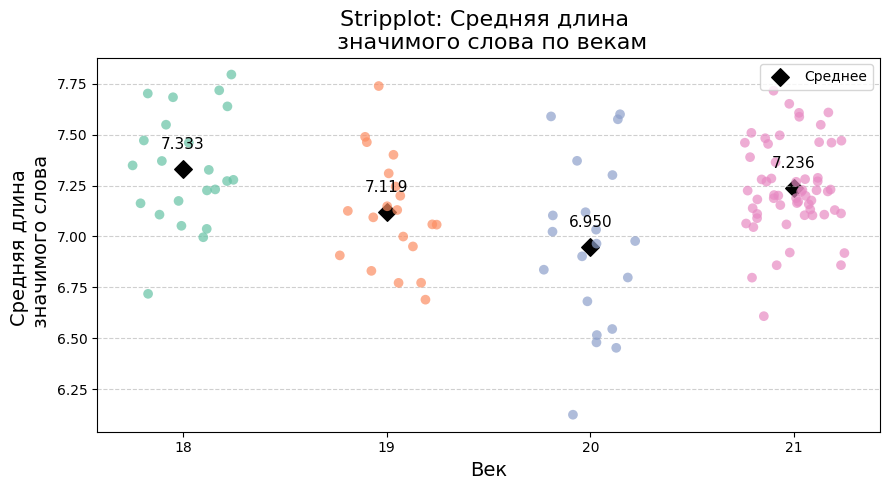

Kruskal-Wallis test для метрики 'Средняя длина 
 значимого слова' по векам: p-value = 0.00074


In [84]:
analyze_metric_by_century(df_metrics, 'avg_word_len_lemmas')


18 век:
Средняя длина слова самая высокая —  7,333 символов.

19 век:
Средняя длина слова снизилась до 7,119.

20 век:
Среднее значение ещё ниже — 6,950, и разброс очень большой (от 6 до 7,7). Здесь видно, что стиль и словарный запас сильно варьируются. Возможно, влияние модернизма и разнообразия стилей в литературе.

21 век:
Средняя длина слова выросла до 7,236.

Вывод:
Средняя длина слова постепенно уменьшалась с 18 до 20 века, что может отражать тенденцию к более простому языку и стилю. Однако в XXI веке наблюдается небольшой рост средней длины слова, что может указывать на возвращение к более богатой или сложной лексике, либо на влияние новых жанров и авторских стилей.

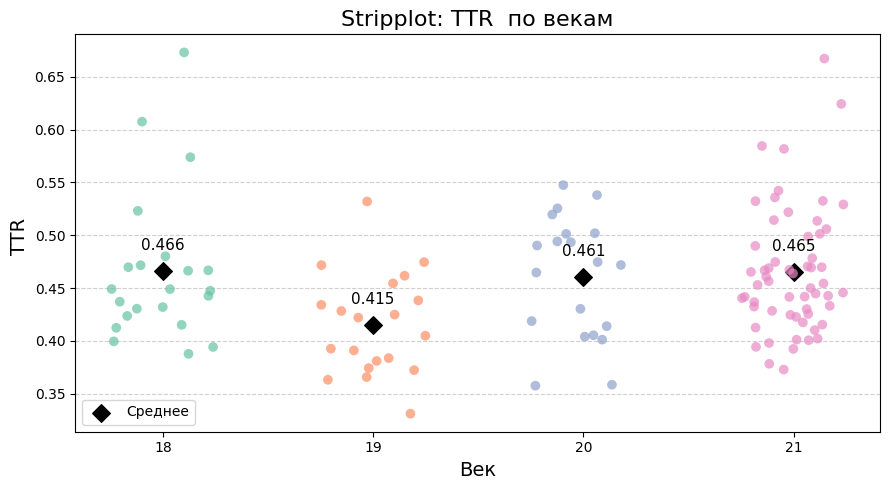

Kruskal-Wallis test для метрики 'TTR ' по векам: p-value = 0.00864


In [86]:
analyze_metric_by_century(df_metrics, 'ttr')

Лексическое разнообразие в XIX веке ниже всего. Это может быть связано с жанровой спецификой или стилем текстов (например, повествование с повторяющимся словарным составом). Остальные века почти не отличаются.

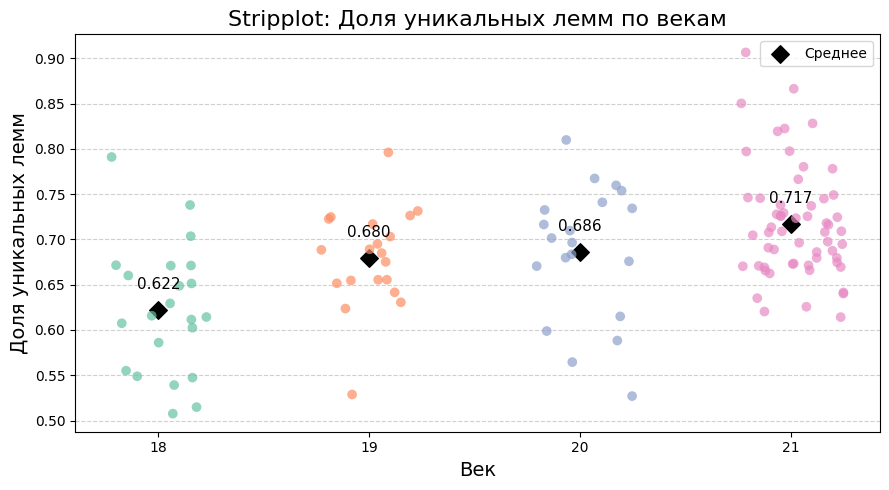

Kruskal-Wallis test для метрики 'Доля уникальных лемм' по векам: p-value = 0.00001


In [87]:
analyze_metric_by_century(df_metrics, 'unique_lemmas_ratio')

Чётко прослеживается рост доли уникальных лемм от XVIII к XXI веку. Это может отражать:

- всё большее лексическое разнообразие в текстах;
- меньшее повторение одних и тех же слов;
- влияние новых тем и жанров, особенно в XXI веке.

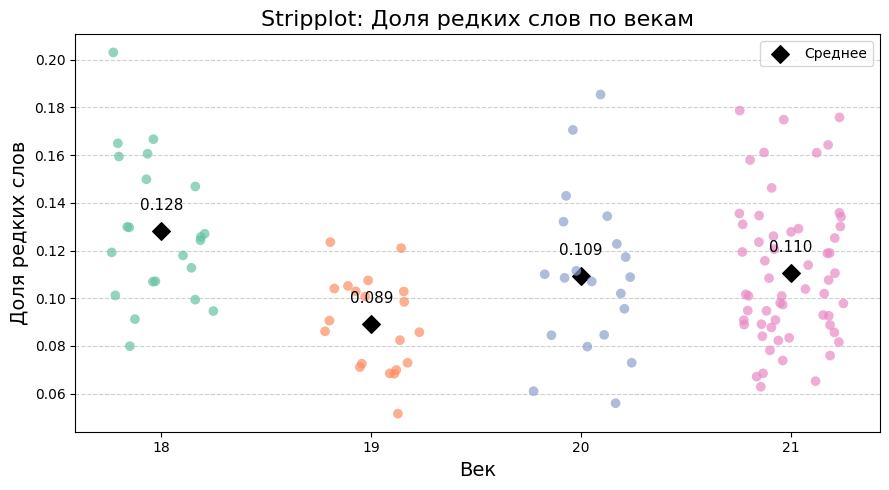

Kruskal-Wallis test для метрики 'Доля редких слов' по векам: p-value = 0.00081


In [88]:
analyze_metric_by_century(df_metrics, 'all_rare_words_ratio')

XVIII век явно выделяется: высокая доля редких слов может отражать:
- архаичную лексику, утратившую частотность в более поздних эпохах;
- специфический стиль и словоупотребление классических текстов.

XIX век — наименьшая доля редкой лексики, вероятно, из-за:
- большей унификации литературного языка;
- ориентации на понятность и массовость.

XX–XXI века демонстрируют умеренную долю редкой лексики, однако с большим разбросом значений, возможно, из-за появления неологизмов, жаргона, разговорных форм, которые система может интерпретировать как редкие слова.

Интересное наблюдение: кривая по векам выглядит U-образно — снижение к XIX веку и постепенное восстановление доли редкой лексики к XXI. Это может отражать смену норм: от архаичности → к нормативности → к стилистическому разнообразию.

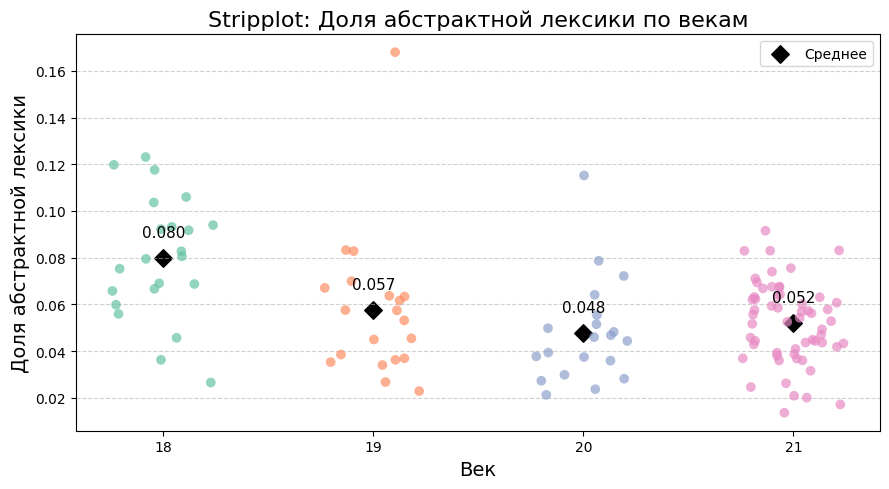

Kruskal-Wallis test для метрики 'Доля абстрактной лексики' по векам: p-value = 0.00007


In [89]:
analyze_metric_by_century(df_metrics, 'abstract_noun_ratio')

С XVIII до XX века наблюдается постепенное и довольно стабильное снижение доли абстрактной лексики. Это может отражать исторический сдвиг от философской, назидательной, риторической прозы к более конкретному, реалистическому и описательному стилю.
После XX века наблюдается небольшой рост доли абстрактной лексики.

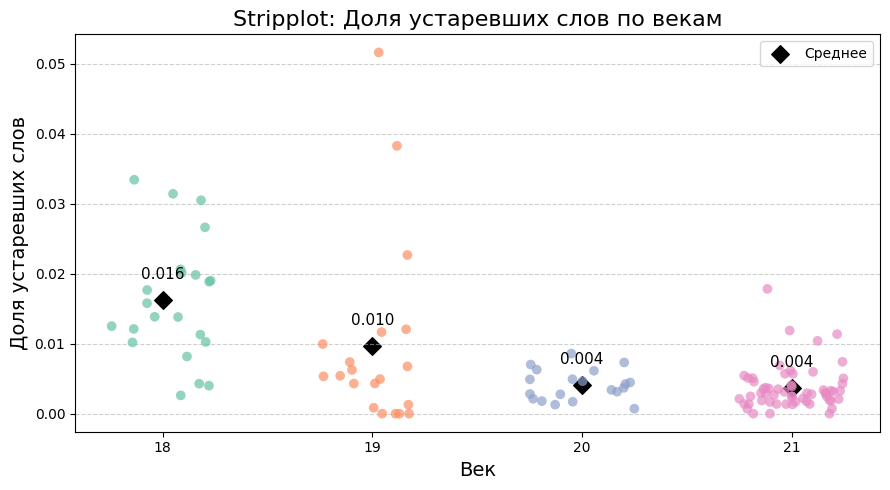

Kruskal-Wallis test для метрики 'Доля устаревших слов' по векам: p-value = 0.00000


In [90]:
analyze_metric_by_century(df_metrics, 'archaic_ratio')

Топ-20 устаревших слов

In [91]:
# список всех архаизмов
all_archaic_words = [word for words_list in df_texts['archaic_words'] for word in words_list]

# частоты
archaic_freq = Counter(all_archaic_words)

# 20 самых частотных
top_archaic = archaic_freq.most_common(20)

print("Топ-20 самых частотных архаизмов:")
for word, freq in top_archaic:
    print(f"{word}: {freq}")

Топ-20 самых частотных архаизмов:
оный: 187
деньга: 165
князь: 45
смотритель: 39
чин: 28
бабка: 26
губернатор: 21
орать: 18
дядька: 15
полок: 13
тулуп: 11
трактир: 10
годиться: 10
благой: 9
полдень: 9
паче: 9
ниже: 9
полно: 9
войт: 9
лютый: 8


Облака слов для каждого века

In [97]:
import ast

df_metrics['content_lemmas'] = df_metrics['content_lemmas'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

In [98]:
# общие списки лемм для каждого века

lemmas_by_century = df_metrics.groupby('century')['content_lemmas'].apply(lambda lists: [lemma for sublist in lists for lemma in sublist])

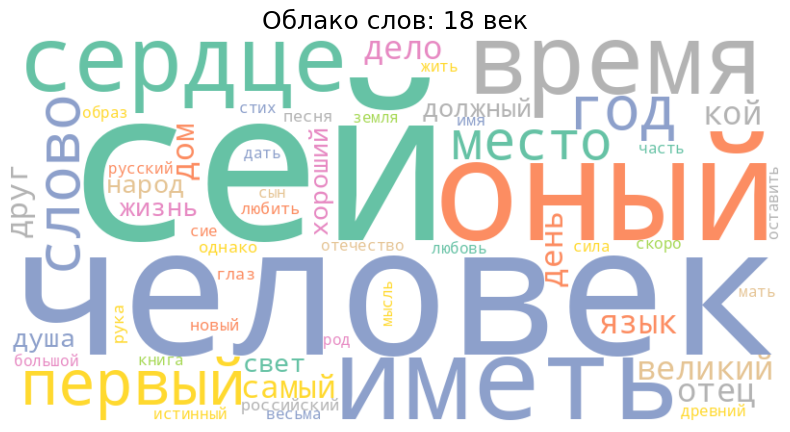

In [100]:
def plot_wordcloud(lemmas, title, max_words=55):
    freq = Counter(lemmas)
    wc = WordCloud(width=800, height=400, background_color='white', colormap='Set2', max_words=max_words)
    wc.generate_from_frequencies(freq)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=18)
    plt.show()


plot_wordcloud(lemmas_by_century[18], 'Облако слов: 18 век', max_words=55)


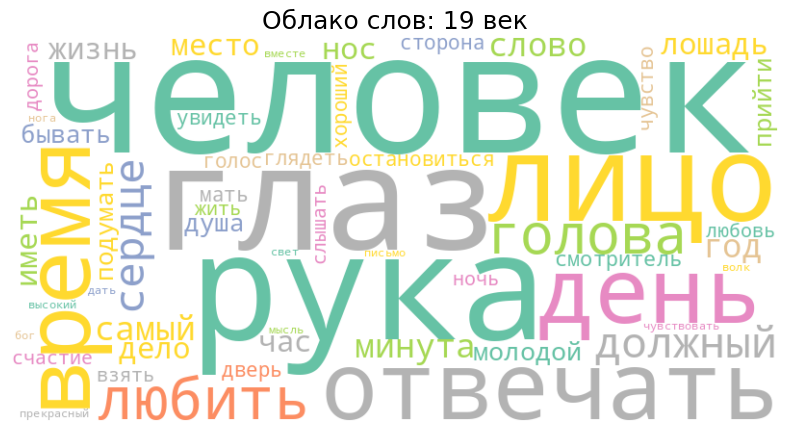

In [101]:
plot_wordcloud(lemmas_by_century[19], 'Облако слов: 19 век', max_words=55)

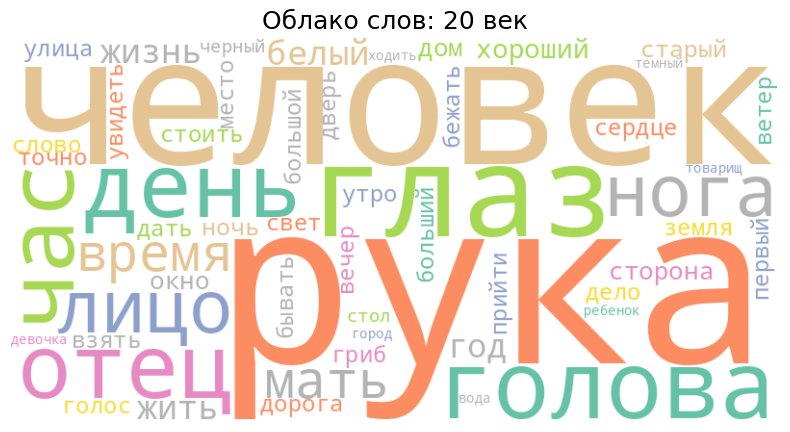

In [102]:
plot_wordcloud(lemmas_by_century[20], 'Облако слов: 20 век', max_words=55)

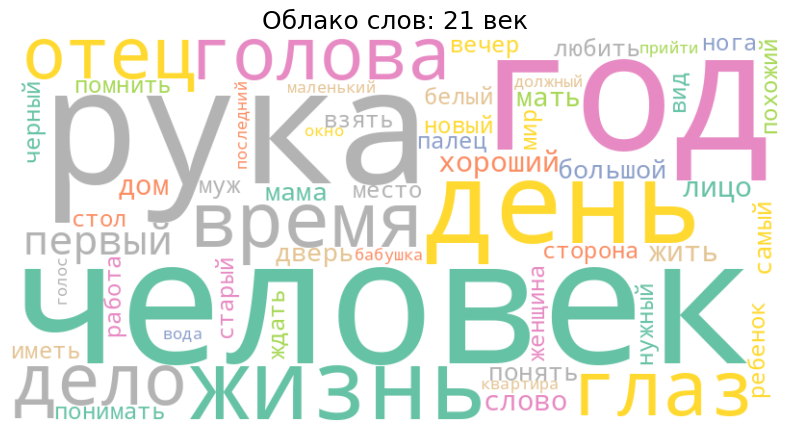

In [103]:
plot_wordcloud(lemmas_by_century[21], 'Облако слов: 21 век', max_words=55)

In [104]:
texts_by_century = {
    century: " ".join(lemmas)
    for century, lemmas in lemmas_by_century.items()
}

# df для удобства
tfidf_df = pd.DataFrame.from_dict(texts_by_century, orient='index', columns=['text'])

# TF-IDF векторизация
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(tfidf_df['text'])

# список лемм (признаков)
feature_names = vectorizer.get_feature_names_out()

tfidf_result = pd.DataFrame(tfidf_matrix.toarray(), index=tfidf_df.index, columns=feature_names)

# функция для получения топа слов с самым высоким TF-IDF в веке
def get_top_tfidf_words(tfidf_row, top_n=15):
    sorted_items = tfidf_row.sort_values(ascending=False).head(top_n)
    return list(zip(sorted_items.index, sorted_items.values))

# топ-15 слов для 18 века
top_18 = get_top_tfidf_words(tfidf_result.loc[18])

print("Топ-15 характерных слов для 18 века:")
for word, score in top_18:
    print(f"{word}: {score:.4f}")

Топ-15 характерных слов для 18 века:
сей: 0.3199
человек: 0.2943
оный: 0.2752
иметь: 0.2116
время: 0.1472
сердце: 0.1265
первый: 0.1180
слово: 0.1107
год: 0.1107
место: 0.1070
великий: 0.1022
дело: 0.0997
отец: 0.0997
язык: 0.0973
кой: 0.0961


In [105]:
# топ-15 слов для 19 века
top_19 = get_top_tfidf_words(tfidf_result.loc[19])

print("Топ-15 характерных слов для 19 века:")
for word, score in top_19:
    print(f"{word}: {score:.4f}")

Топ-15 характерных слов для 19 века:
человек: 0.2224
рука: 0.1687
то: 0.1649
глаз: 0.1631
лицо: 0.1594
смотритель: 0.1385
отвечать: 0.1371
день: 0.1297
время: 0.1297
любить: 0.1242
голова: 0.1131
должный: 0.1112
сердце: 0.1112
нос: 0.1111
самый: 0.1075


In [106]:
# топ-15 слов для 20 века
top_20 = get_top_tfidf_words(tfidf_result.loc[20])

print("Топ-15 характерных слов для 20 века:")
for word, score in top_20:
    print(f"{word}: {score:.4f}")

Топ-15 характерных слов для 20 века:
рука: 0.2484
человек: 0.2339
глаз: 0.1682
то: 0.1490
голова: 0.1378
час: 0.1346
день: 0.1250
отец: 0.1234
лицо: 0.1218
нога: 0.1186
мать: 0.1122
время: 0.1122
белый: 0.1074
жить: 0.1058
жизнь: 0.1042


In [107]:
# топ-15 слов для 21 века
top_21 = get_top_tfidf_words(tfidf_result.loc[21])

print("Топ-15 характерных слов для 21 века:")
for word, score in top_21:
    print(f"{word}: {score:.4f}")

Топ-15 характерных слов для 21 века:
человек: 0.2084
то: 0.1869
год: 0.1847
рука: 0.1756
день: 0.1474
жизнь: 0.1468
время: 0.1293
глаз: 0.1276
мама: 0.1178
голова: 0.1141
отец: 0.1118
дело: 0.1113
первый: 0.1090
хороший: 0.1028
жить: 0.1005


Посмотрим слова, которые встречаются только в текстах 21 века.

In [109]:
lemmas_sets = {century: set(lemmas) for century, lemmas in lemmas_by_century.items()}

lemmas_21 = lemmas_sets[21]
other_lemmas = set().union(*[lemmas for c, lemmas in lemmas_sets.items() if c != 21])

unique_21_lemmas = lemmas_21 - other_lemmas

print(f"Уникальных лемм XXI века: {len(unique_21_lemmas)}")
print(sorted(list(unique_21_lemmas))[:50])  # пример


Уникальных лемм XXI века: 10538
['а-а-а', 'а-цзы', 'абажур', 'аббревиатура', 'абзац', 'або', 'абориген', 'абразавание', 'абрикосовый', 'абсолютно', 'абстрактный', 'авангард', 'аванс', 'авантюра', 'аварийка', 'авария', 'авиатор', 'авто', 'автобус', 'автобусный', 'автомат', 'автоматический', 'автоматный', 'автопортрет', 'авторитетный', 'автосервис', 'агапкин', 'агатовый', 'агент', 'агентство', 'агитатор', 'агитация', 'агитировать', 'агония', 'агрегат', 'агрессивный', 'агрессия', 'адаптация', 'адекватный', 'адепт', 'адмирал', 'адмиралтейский', 'адов', 'адресат', 'азартно', 'азбука', 'азот', 'айсберг', 'айфон', 'академик']


In [110]:
all_21_lemmas = lemmas_by_century[21]

# Оставим только те, которые уникальны
filtered = [lemma for lemma in all_21_lemmas if lemma in unique_21_lemmas]

freq_counter = Counter(filtered)
most_common_unique_21 = freq_counter.most_common(20)

print("Частотные уникальные леммы XXI века:")
for lemma, freq in most_common_unique_21:
    print(f"{lemma}: {freq}")

Частотные уникальные леммы XXI века:
смочь: 53
тетрадь: 24
местный: 23
компьютер: 22
клиент: 21
похоже: 21
попытаться: 20
готовить: 19
закончить: 19
ванная: 18
воронка: 17
эф: 17
руна: 17
альбом: 16
полностью: 16
программа: 16
сигарета: 16
мамочка: 16
пленный: 16
наверняка: 15


# **Синтаксис**

Посмотрим графики распределения следующих метрик:

- средняя длина предложения;
- средняя глубина синтаксического дерева;
- доля подчинительных союзов.

Также для каждой метрики проведём тест Крускала-Уоллиса и проверим, есть ли статистически значимые различия между веками.

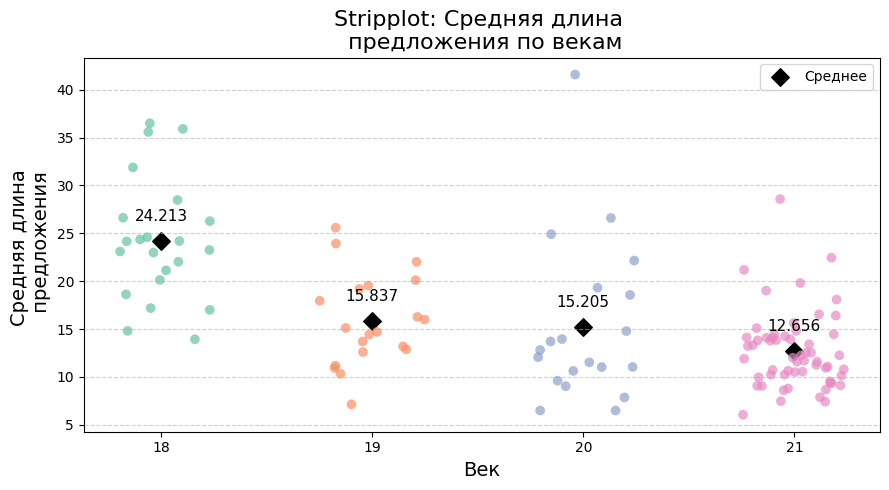

Kruskal-Wallis test для метрики 'Средняя длина 
 предложения' по векам: p-value = 0.00000


In [111]:
analyze_metric_by_century(df_metrics, 'avg_sent_len')

XVIII век: средняя длина предложения достигает 24 слов — это самый высокий показатель. Вероятно, тексты этого периода характеризуются длинными, многокомпонентными структурами, что типично для классической письменной речи того времени.

XIX век: средняя длина заметно сокращается до 15,8, что может отражать переход к более разговорной и динамичной прозе, характерной, например, для реализма.

XX век: средняя длина продолжает снижаться до 15,2 — изменения уже не такие резкие, но очевидно движение в сторону более кратких синтаксических единиц.

XXI век: предложения становятся ещё короче — в среднем 12,6 слов, что может быть связано с возрастающим влиянием разговорной речи, медиа, блогов, а также стремлением к простоте и лаконичности в стиле.

С течением времени наблюдается устойчивая тенденция к упрощению синтаксической структуры: предложения становятся всё короче, что, вероятно, связано с изменениями в жанрах, целевой аудитории и функциях текста.

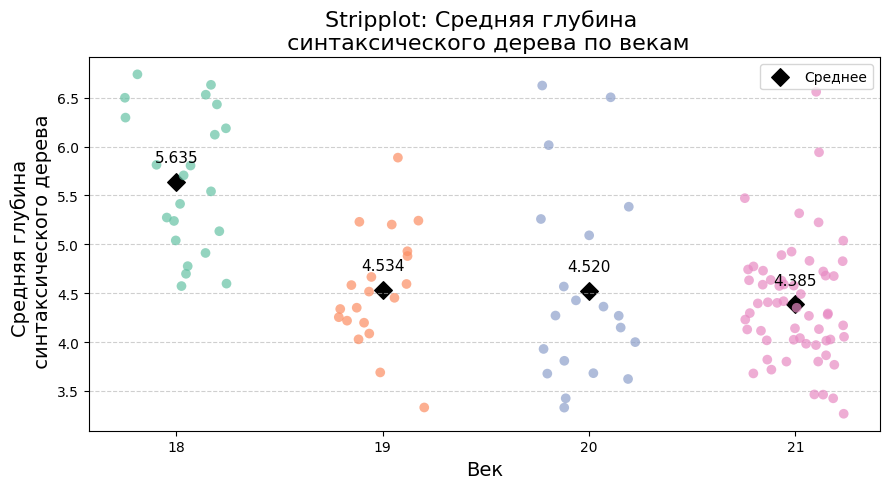

Kruskal-Wallis test для метрики 'Средняя глубина 
 синтаксического дерева' по векам: p-value = 0.00000


In [112]:
analyze_metric_by_century(df_metrics, 'avg_tree_depth')

Общее снижение глубины.

Тексты 18 века характеризуются более сложными синтаксическими структурами.

Впоследствии (19–21 вв.) наблюдается тенденция к упрощению синтаксиса, что может отражать:

- общую демократизацию литературного языка;

- ориентацию на устную речь;

- появление новых жанров (диалоги, внутренние монологи, поток сознания и т.д.).

Разброс значений наиболее широкий у 20–21 веков, что может говорить о разнообразии стилей и авторских стратегий синтаксиса.

У 18 века разброс меньше — возможно, синтаксис был более стандартизированным или консервативным.

Теперь посмотрим на корреляцию этих двух метрик. Если корреляция сильно меняется по векам, это может указывать на изменения в стилевых предпочтениях: например, в одном веке длинные предложения — это просто перечисления (низкая глубина), а в другом — сложносочинённые или сложноподчинённые конструкции (высокая глубина).

In [113]:
corr_results = []

for century, group in df_metrics.groupby('century'):
    corr_coef, p_val = pearsonr(group['avg_sent_len'], group['avg_tree_depth'])
    corr_results.append({
        'century': century,
        'correlation': round(corr_coef, 4),
        'p_value': f"{p_val:.7f}"
    })

corr_df = pd.DataFrame(corr_results)
print(corr_df)

   century  correlation    p_value
0       18       0.5507  0.0079085
1       19       0.9292  0.0000000
2       20       0.9299  0.0000000
3       21       0.9630  0.0000000


Во всех анализируемых периодах наблюдается статистически значимая положительная корреляция между длиной предложения и глубиной синтаксического дерева. Особенно сильной она становится с XIX века, что отражает усложнение синтаксических конструкций в более длинных фразах. В XVIII веке зависимость была слабее, возможно из-за особенностей синтаксической структуры этого периода.Стиль XVIII века мог включать длинные, но менее вложенные конструкции (например, через простое усложнение лексики и пунктуации, а не вложенные придаточные).

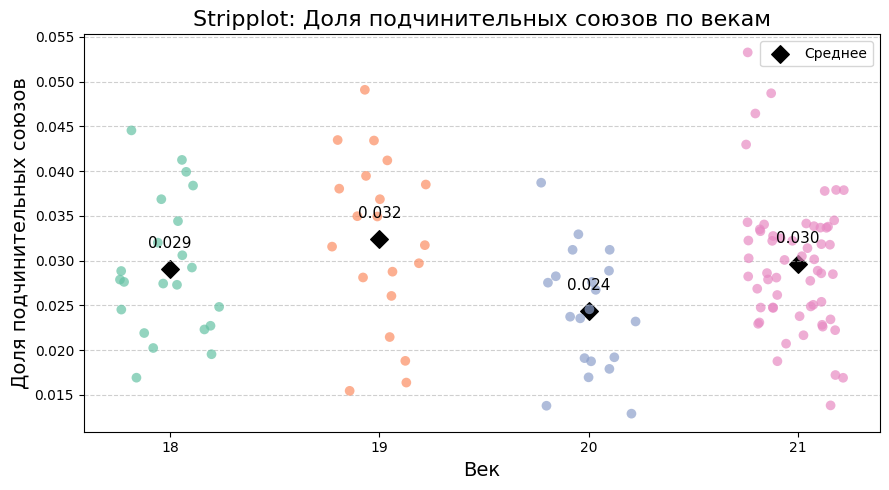

Kruskal-Wallis test для метрики 'Доля подчинительных союзов' по векам: p-value = 0.01211


In [114]:
analyze_metric_by_century(df_metrics, 'subordinating_conj_ratio')

Наибольшая доля подчинительных союзов наблюдается в XIX веке, что соответствует усложнению синтаксиса в классической литературе. XX век демонстрирует сокращение этих конструкций, что может отражать сдвиг к более лаконичному, экспериментальному стилю. В XXI веке происходит частичное возвращение к подчинённой синтаксической структуре.

Использование причастий снижается в XIX веке, что согласуется с реалистической традицией живой речи и упрощённого синтаксиса. Однако в XX веке причастия возвращаются как выразительное средство, и в XXI веке сохраняются на стабильно высоком уровне, возможно, отражая тенденцию к стилевому смешению и возврату книжной нормы в "высокой" литературе.

## **Морфология**

Посмотрим графики распределения следующих метрик:

- частотность прилагательных;
- частотность наречий;
- доля пассивных конструкций;
- доля причастий;
- доля деепричастий.

Также для каждой метрики проведём тест Крускала-Уоллиса и проверим, есть ли статистически значимые различия между веками.

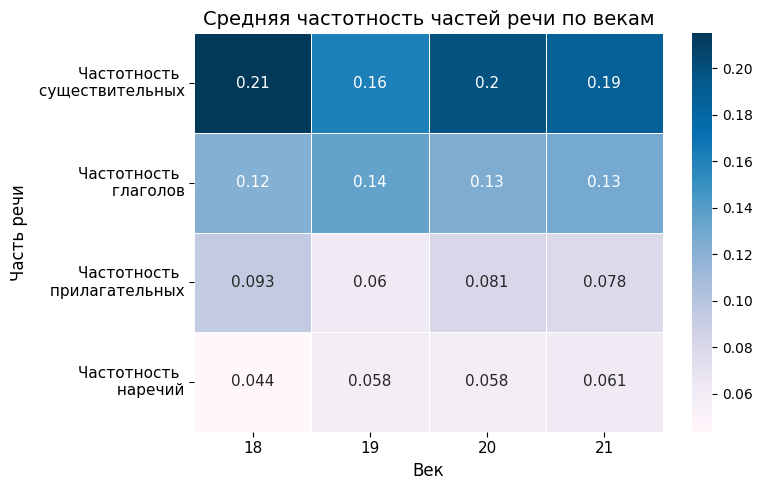

In [116]:
pos_metrics = ['freq_noun', 'freq_verb', 'freq_adj', 'freq_adv']

# средние значения частот по векам
pos_by_century = df_metrics.groupby('century')[pos_metrics].mean().T

# меняем технические названия на пользовательские
pos_by_century.index = [metric_names.get(metric, metric) for metric in pos_by_century.index]

plt.figure(figsize=(8, 5))
sns.heatmap(
    pos_by_century,
    annot=True,
    cmap='PuBu',
    linewidths=0.5,
    annot_kws={"fontsize": 11},  # размер текста внутри ячеек

)
plt.title('Средняя частотность частей речи по векам', fontsize=14)
plt.xlabel('Век', fontsize=12)
plt.ylabel('Часть речи', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()

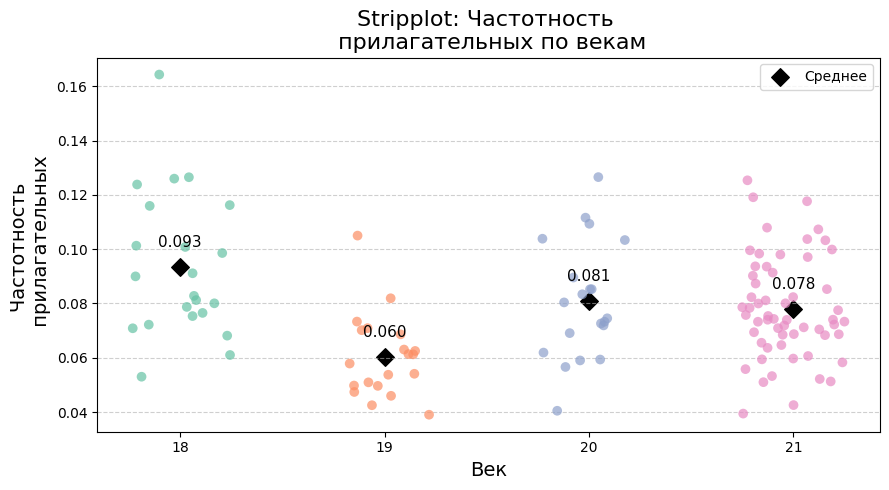

Kruskal-Wallis test для метрики 'Частотность 
 прилагательных' по векам: p-value = 0.00003


In [117]:
analyze_metric_by_century(df_metrics, 'freq_adj')

Частотность прилагательных была максимальной в XVIII веке, отражая риторический стиль и тяготение к высокой описательности. В XIX веке происходит резкое снижение, соответствующее реалистической установке на сдержанный, нейтральный язык. XX и XXI века демонстрируют возвращение к более выразительной лексике — возможно, в рамках постмодернистской свободы стиля и образного насыщения текста.

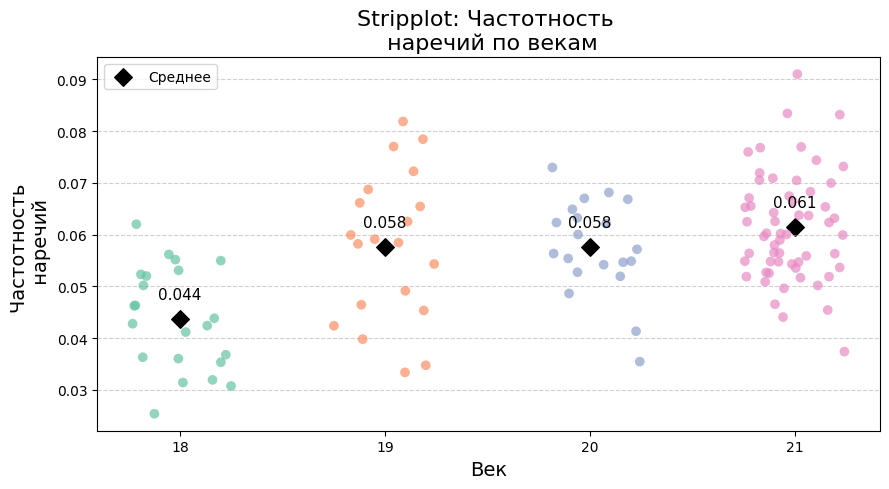

Kruskal-Wallis test для метрики 'Частотность 
 наречий' по векам: p-value = 0.00000


In [118]:
analyze_metric_by_century(df_metrics, 'freq_adv')

Наречия:

- уточняют действия (бежать быстро, говорить уверенно);

- добавляют оценочность (ужасно красиво, невероятно важно);

- часто выражают субъективность — мнение, точку зрения говорящего.

Частотность наречий заметно растёт от XVIII к XXI веку. Это может отражать как усиление динамики и субъективности повествования в более поздней прозе, так и стилистическую разговорность и эмоциональность, свойственную современной литературе.

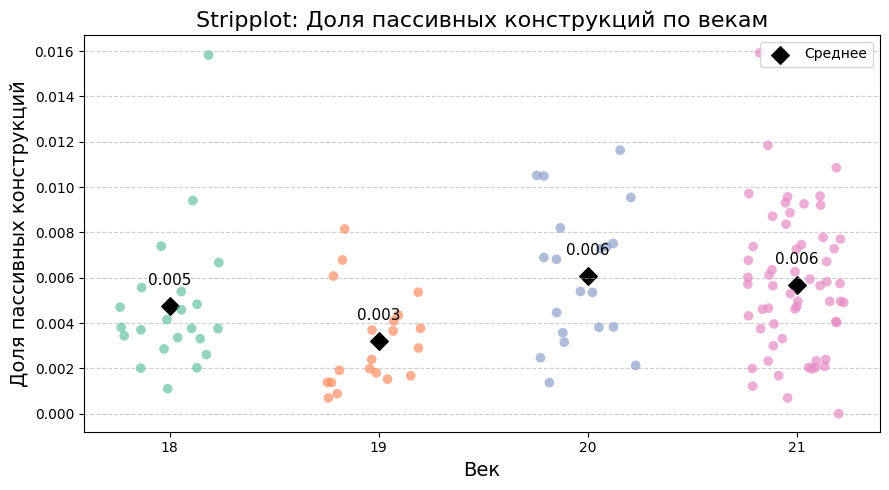

Kruskal-Wallis test для метрики 'Доля пассивных конструкций' по векам: p-value = 0.00118


In [119]:
analyze_metric_by_century(df_metrics, 'passive_ratio')

XVIII век — умеренно высокая доля (0.050)
Страдательный залог был характерен для официального, книжного и риторического стиля, особенно под влиянием канцелярской и церковной речи.

XIX век — минимальное значение (0.030)
Век реалистической литературы, где предпочтение отдаётся активному залогу.

XX и XXI века — значительный рост (0.060)
Возврат и даже превышение уровня XVIII века. Возможно, влияние научного, официального и журналистского стиля.



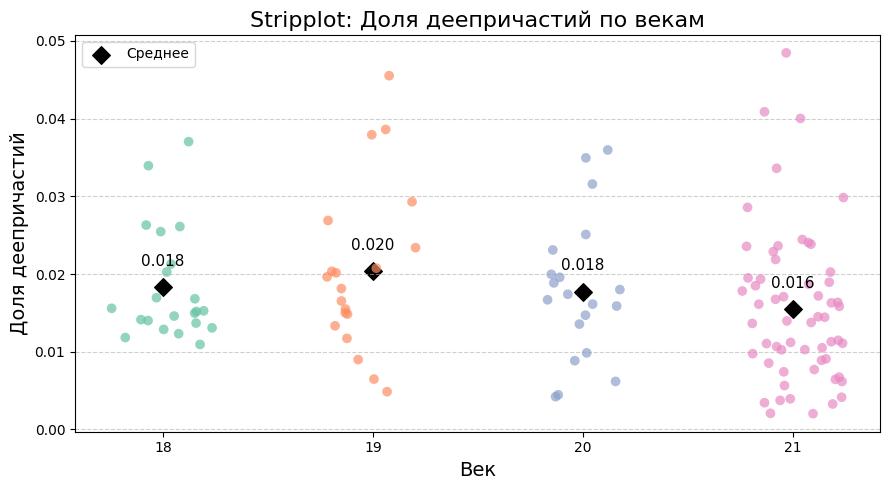

Kruskal-Wallis test для метрики 'Доля деепричастий' по векам: p-value = 0.14020


In [120]:
analyze_metric_by_century(df_metrics, 'gerund_ratio')

Деепричастные конструкции сохраняют стабильное присутствие в литературных текстах всех эпох, достигая максимума в XIX веке. В XXI веке наблюдается умеренное снижение, но по разбросу можно предположить, что это связано с наличием в корпусе текстов массовой литературы.

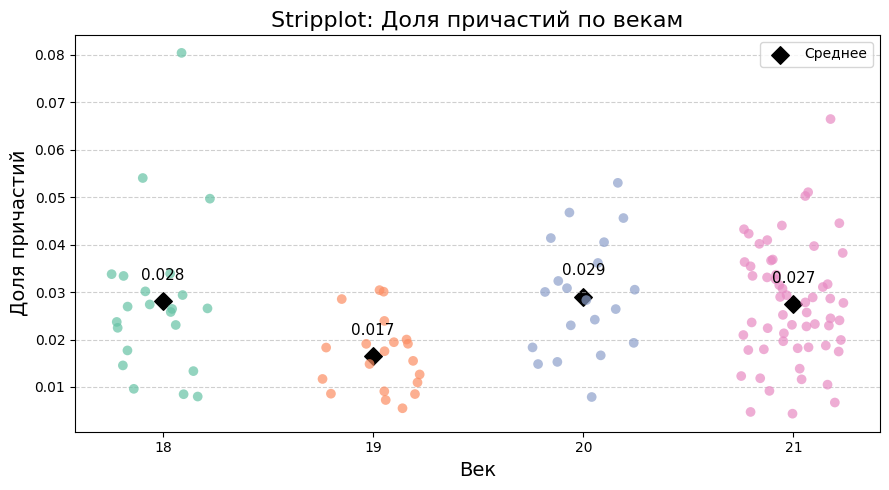

Kruskal-Wallis test для метрики 'Доля причастий' по векам: p-value = 0.00175


In [121]:
analyze_metric_by_century(df_metrics, 'participle_ratio')

Использование причастий снижается в XIX веке, что согласуется с реалистической традицией живой речи и упрощённого синтаксиса. Однако в XX веке причастия возвращаются как выразительное средство, и в XXI веке сохраняются на стабильно высоком уровне, возможно, отражая тенденцию к стилевому смешению и возврату книжной нормы в "высокой" литературе.

## **Индекс Флеша**

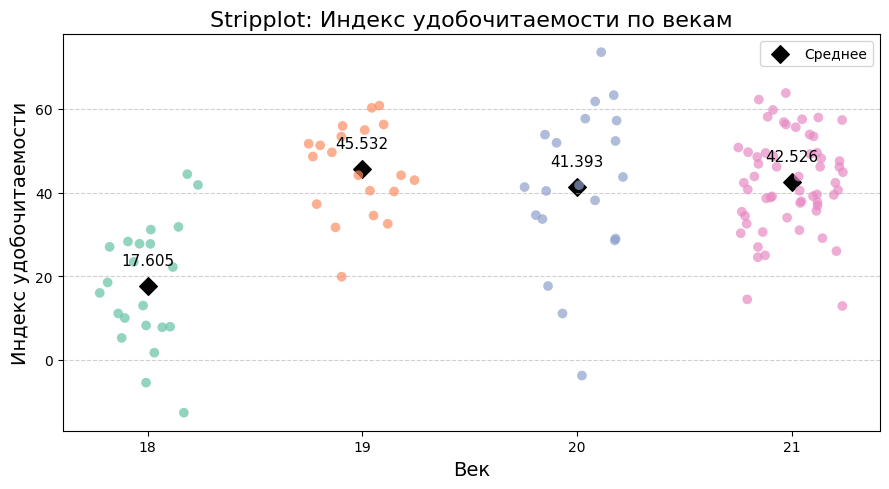

Kruskal-Wallis test для метрики 'Индекс удобочитаемости' по векам: p-value = 0.00000


In [123]:
analyze_metric_by_century(df_metrics, 'readability_index')

## **Сравнение метрик по векам.**

Средние значения по каждому веку.

In [124]:
metrics = [
    'avg_word_len',      # cредняя длина слова
    'ttr',               # TTR
    'unique_lemmas_ratio',# доля уникальных лемм
    'all_rare_words_ratio',   # доля редких слов
    'freq_adj',          # частотность прилагательных
    'freq_adv',          # частотность наречий
    'avg_tree_depth',  # средняя глубина синтаксического дерева
    'avg_sent_len',   # средняя длина предложения
    'subordinating_conj_ratio', # доля подчинительных союзов
    'archaic_ratio', # доля устаревших слов
    'abstract_noun_ratio', # доля абстрактной лексики
    'readability_index', # индекс удобочитаемости
    'passive_ratio', # доля пассивных конструкций
    'participle_ratio', # доля причастий
    'gerund_ratio', # доля деепричастий
    'diminutive_ratio', # доля уменьшительно-ласкательных
    'slang_ratio', # доля просторечий
    'gen_chain_share' # доля генетивных цепочек

]

# группируем по веку и считаем среднее и std для каждой метрики
summary_stats = df_metrics.groupby('century')[metrics].agg(['mean'])

# для удобства сделаем плоский индекс
summary_stats.columns = ['_'.join(col).strip() for col in summary_stats.columns.values]

# сбросим индекс, чтобы 'century' была колонкой
summary_stats = summary_stats.reset_index()

print(summary_stats)

   century  avg_word_len_mean  ttr_mean  unique_lemmas_ratio_mean  \
0       18           5.456685  0.465994                  0.622095   
1       19           4.979026  0.415054                  0.679766   
2       20           5.196552  0.460596                  0.686286   
3       21           5.312519  0.465009                  0.716970   

   all_rare_words_ratio_mean  freq_adj_mean  freq_adv_mean  \
0                   0.128102       0.093395       0.043743   
1                   0.089291       0.060473       0.057678   
2                   0.109381       0.080880       0.057508   
3                   0.110500       0.078130       0.061380   

   avg_tree_depth_mean  avg_sent_len_mean  subordinating_conj_ratio_mean  \
0             5.635133          24.212714                       0.029054   
1             4.534440          15.837391                       0.032396   
2             4.520368          15.205030                       0.024329   
3             4.384849          12.6560

Усреднённые значения по классике.

In [125]:
classic_df = summary_stats[summary_stats['century'].isin([18, 19, 20])]

metrics_only = [col for col in classic_df.columns if col != 'century']
classic_means = classic_df[metrics_only].mean()

classic_means

,0
avg_word_len_mean,5.210754
ttr_mean,0.447215
unique_lemmas_ratio_mean,0.662716
all_rare_words_ratio_mean,0.108925
freq_adj_mean,0.078249
freq_adv_mean,0.052976
avg_tree_depth_mean,4.896647
avg_sent_len_mean,18.418378
subordinating_conj_ratio_mean,0.028593
archaic_ratio_mean,0.009992


Средние значения по трём категориям современной русской прозы (хорошая, нейтральная, массовая).

In [126]:
metrics = [
    'avg_word_len', 'ttr', 'unique_lemmas_ratio', 'all_rare_words_ratio', 'freq_adj', 'freq_adv',
    'avg_tree_depth', 'avg_sent_len', 'subordinating_conj_ratio', 'abstract_noun_ratio', 'archaic_ratio',
    'readability_index', 'passive_ratio', 'participle_ratio', 'gerund_ratio', 'diminutive_ratio', 'slang_ratio', 'gen_chain_share'
]

df_modern = df_texts[df_texts['century'] == 21]

modern_cat_summary = df_modern.groupby('cat')[metrics].mean().reset_index()

print(modern_cat_summary)

              cat  avg_word_len       ttr  unique_lemmas_ratio  \
0     modern_good      5.353595  0.501590             0.747435   
1     modern_mass      5.239173  0.428984             0.683152   
2  modern_neutral      5.335661  0.456324             0.713551   

   all_rare_words_ratio  freq_adj  freq_adv  avg_tree_depth  avg_sent_len  \
0              0.124157  0.086256  0.058734        4.628653     14.279751   
1              0.092200  0.070521  0.066208        4.088783     10.841671   
2              0.112107  0.075806  0.059786        4.382932     12.486007   

   subordinating_conj_ratio  abstract_noun_ratio  archaic_ratio  \
0                  0.029638             0.052557       0.003142   
1                  0.031552             0.052701       0.003576   
2                  0.027810             0.050683       0.004480   

   readability_index  passive_ratio  participle_ratio  gerund_ratio  \
0          38.826352       0.007132          0.031053      0.017046   
1          47.0

Просмотр метрик по каждому современному произведению.

In [127]:
modern_texts_metrics = df_modern[['author', 'title', 'cat'] + metrics].copy()

print(modern_texts_metrics.to_string(index=False))

                 author                                   title            cat  avg_word_len      ttr  unique_lemmas_ratio  all_rare_words_ratio  freq_adj  freq_adv  avg_tree_depth  avg_sent_len  subordinating_conj_ratio  abstract_noun_ratio  archaic_ratio  readability_index  passive_ratio  participle_ratio  gerund_ratio  diminutive_ratio  slang_ratio  gen_chain_share
            В.Г.Сорокин                                Манарага    modern_good      5.513805 0.498697             0.697479              0.130083  0.099583  0.044056        4.171233     10.550173                  0.017205             0.042827       0.003601          37.704322       0.007776          0.040965      0.006173          0.009658     0.130214         0.000791
          М.М.Степанова                   Памяти памяти. Романс    modern_good      5.376244 0.474670             0.724543              0.134086  0.107930  0.054791        6.560748     28.575472                  0.032214             0.069393       0.003264  

Посмотрим, выбиваются ли какие-то тексты внутри своих категорий.

In [ ]:
# z-оценки по всем метрикам
z_scores = modern_texts_metrics[metrics].apply(zscore)

# строки, где хотя бы одна метрика выбивается (|z| > 2)
outlier_mask = (z_scores.abs() > 2).any(axis=1)

# тексты с выбросами
outliers = modern_texts_metrics.loc[outlier_mask].copy()
outliers_z = z_scores.loc[outlier_mask].copy()

# добавим к outliers информацию о выбивающихся метриках
def highlight_outliers(row):
    return {
        metric: f"{row[metric]:+.2f}"
        for metric in metrics if abs(row[metric]) > 2
    }

outliers['выбивающиеся_метрики'] = outliers_z.apply(highlight_outliers, axis=1)

# только информативные столбцы
outliers_info = outliers[['author', 'title', 'cat', 'выбивающиеся_метрики']]

pd.set_option('display.max_colwidth', None)
print(outliers_info.sort_values(by='cat'))

                  author                           title             cat  \
63         М.М.Степанова           Памяти памяти. Романс     modern_good   
64           Т.Н.Толстая                            Кысь     modern_good   
66            П.В.Санаев    Похороните меня за плинтусом     modern_good   
67          М.Ю.Елизаров                           Земля     modern_good   
68             Г.Ш.Яхина         Зулейха открывает глаза     modern_good   
69        Е.Г.Водолазкин                            Лавр     modern_good   
70        С.А.Алексиевич       У войны - не женское лицо     modern_good   
71           А.П.Чудаков  Ложится мгла на старые ступени     modern_good   
72             Г.Ш.Яхина                        Дети мои     modern_good   
73       Мариам Петросян                  Дом, в которм…     modern_good   
76            Д.И.Рубина                Синдром Петрушки     modern_good   
80           Л.Е.Улицкая                   Зеленый шатер     modern_good   
105       О.

Составим сводную таблицу и сравним средние значения классики с разными категориями современной литературы.

In [ ]:
metric_columns = [
    'avg_word_len_mean', 'ttr_mean', 'unique_lemmas_ratio_mean', 'all_rare_words_ratio_mean',
    'freq_adj_mean', 'freq_adv_mean', 'avg_tree_depth_mean', 'avg_sent_len_mean',
    'subordinating_conj_ratio_mean', 'abstract_noun_ratio_mean', 'archaic_ratio_mean',
    'readability_index_mean', 'passive_ratio_mean', 'participle_ratio_mean',
    'gerund_ratio_mean', 'diminutive_ratio_mean', 'slang_ratio_mean', 'gen_chain_share_mean'
]

# замена названий на базовые
classic_df = summary_stats[summary_stats['century'].isin([18, 19, 20])]
classic_means = classic_df[metric_columns].mean()
classic_means.index = [col.replace('_mean', '') for col in classic_means.index]
classic_means.name = 'Классика'

# современная
modern_means = df_texts[df_texts['century'] == 21].groupby('cat')[
    classic_means.index
].mean()
modern_means.index = modern_means.index.map({
    'modern_good': 'Хорошая литература',
    'modern_neutral': 'Нейтральная литература',
    'modern_mass': 'Массовая литература'
})

# Объединяем по колонкам, транспонируем для удобства
full_table = pd.concat([classic_means.to_frame().T, modern_means])
full_table = full_table.T

# Заменяем названия метрик на красивые
full_table.index = [metric_names.get(metric, metric) for metric in full_table.index]

# Вывод
pd.set_option('display.max_rows', None)
display(full_table)

,Классика,Хорошая литература,Массовая литература,Нейтральная литература
Средняя длина \n слова,5.210754,5.353595,5.239173,5.335661
TTR,0.447215,0.501590,0.428984,0.456324
Доля уникальных лемм,0.662716,0.747435,0.683152,0.713551
Доля редких слов,0.108925,0.124157,0.092200,0.112107
Частотность \n прилагательных,0.078249,0.086256,0.070521,0.075806
Частотность \n наречий,0.052976,0.058734,0.066208,0.059786
Средняя глубина \n синтаксического дерева,4.896647,4.628653,4.088783,4.382932
Средняя длина \n предложения,18.418378,14.279751,10.841671,12.486007
Доля подчинительных союзов,0.028593,0.029638,0.031552,0.027810
Доля абстрактной лексики,0.061594,0.052557,0.052701,0.050683


Переставим столбцы для удобства.

In [ ]:

full_table = pd.concat([classic_means.to_frame().T, modern_means])
full_table = full_table.T

full_table.index = [metric_names.get(metric, metric) for metric in full_table.index]


desired_order = ['Классика', 'Хорошая литература', 'Нейтральная литература', 'Массовая литература']
full_table = full_table[desired_order]


pd.set_option('display.max_rows', None)
display(full_table)



,Классика,Хорошая литература,Нейтральная литература,Массовая литература
Средняя длина \n слова,5.210754,5.353595,5.335661,5.239173
TTR,0.447215,0.501590,0.456324,0.428984
Доля уникальных лемм,0.662716,0.747435,0.713551,0.683152
Доля редких слов,0.108925,0.124157,0.112107,0.092200
Частотность \n прилагательных,0.078249,0.086256,0.075806,0.070521
Частотность \n наречий,0.052976,0.058734,0.059786,0.066208
Средняя глубина \n синтаксического дерева,4.896647,4.628653,4.382932,4.088783
Средняя длина \n предложения,18.418378,14.279751,12.486007,10.841671
Доля подчинительных союзов,0.028593,0.029638,0.027810,0.031552
Доля абстрактной лексики,0.061594,0.052557,0.050683,0.052701


Тут становится ясно, что "нейтральная" категория слишком размытая, у неё нет чётких метрик. Она одновременно носит черты как высокой, так и массовой литературы. Ради эксперимента была совершена попытка создать классификатор с учётом этой категории, но она (ожидаемо) оказалась провальной. Поэтому было принято решение о бинарной классификации.

## **Классификатор**

Обучаем модель.

In [129]:
df_binary = df_metrics[df_metrics['cat'].isin(['modern_good', 'modern_mass'])]

# признаки
features = [
    'avg_word_len', 'ttr', 'unique_lemmas_ratio', 'all_rare_words_ratio', 'freq_adj', 'freq_adv',
    'avg_tree_depth', 'avg_sent_len', 'subordinating_conj_ratio', 'abstract_noun_ratio', 'archaic_ratio',
    'readability_index', 'passive_ratio', 'participle_ratio', 'gerund_ratio', 'diminutive_ratio', 'slang_ratio', 'gen_chain_share'

]

X = df_binary[features]
y = df_binary['cat']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# гиперпараметры
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2, 4, 6]
}

# модель
gb = GradientBoostingClassifier(random_state=42)

# GridSearchCV — поиск по сетке с кросс-валидацией по train
grid_search = GridSearchCV(gb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Лучшая модель:", grid_search.best_params_)
print(" Accuracy (CV на train):", grid_search.best_score_)

# обучаем модель с лучшими параметрами на всей тренировочной выборке
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# оценка
y_pred = best_model.predict(X_test)
print("Accuracy on test set:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Лучшая модель: {'learning_rate': 0.05, 'max_depth': 4, 'min_samples_split': 6, 'n_estimators': 100}
 Accuracy (CV на train): 0.7533333333333333
Accuracy on test set: 0.75
              precision    recall  f1-score   support

 modern_good       0.75      0.86      0.80         7
 modern_mass       0.75      0.60      0.67         5

    accuracy                           0.75        12
   macro avg       0.75      0.73      0.73        12
weighted avg       0.75      0.75      0.74        12



Чтобы понять, как можно улучшить классификатор, посмотрим наиболее важные признаки.

                     feature  importance
1                        ttr    0.362677
15          diminutive_ratio    0.260633
9        abstract_noun_ratio    0.246154
14              gerund_ratio    0.042806
13          participle_ratio    0.041925
17           gen_chain_share    0.031963
12             passive_ratio    0.013842
0               avg_word_len    0.000000
4                   freq_adj    0.000000
2        unique_lemmas_ratio    0.000000
8   subordinating_conj_ratio    0.000000
7               avg_sent_len    0.000000
6             avg_tree_depth    0.000000
5                   freq_adv    0.000000
3       all_rare_words_ratio    0.000000
11         readability_index    0.000000
10             archaic_ratio    0.000000
16               slang_ratio    0.000000


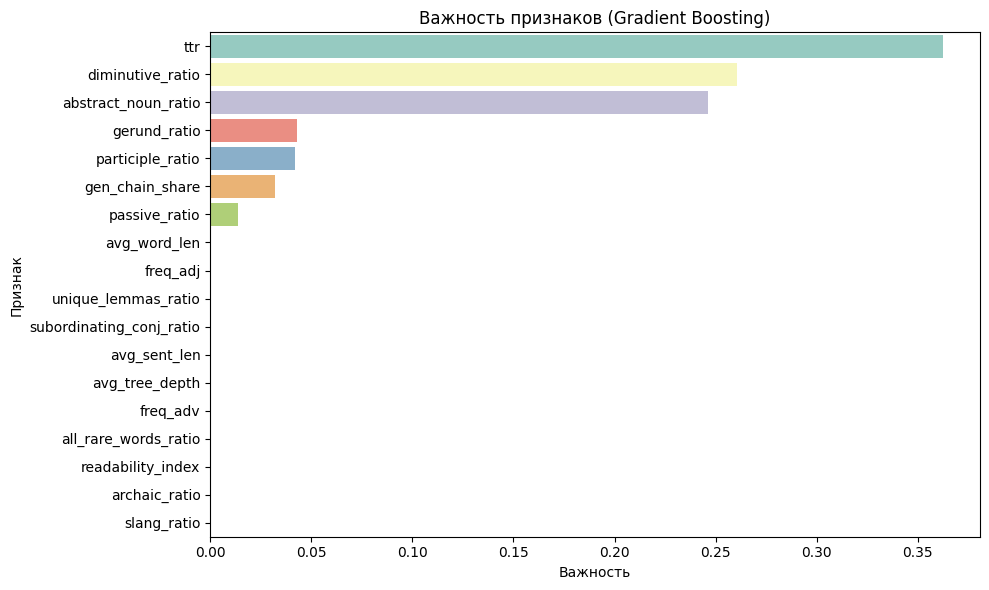

In [131]:
# важности
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values(by='importance', ascending=False)

# Вывод
print(feature_importances)

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances, palette='Set3')
plt.title('Важность признаков (Gradient Boosting)')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

Попробуем улучшить модель, убрав наименее важные метрики.

In [132]:
features_short = [
    'avg_word_len', 'ttr', 'unique_lemmas_ratio', 'freq_adj', 'freq_adv',
    'avg_tree_depth', 'avg_sent_len', 'subordinating_conj_ratio', 'abstract_noun_ratio',
    'passive_ratio', 'participle_ratio', 'gerund_ratio', 'diminutive_ratio', 'gen_chain_share'
]

X_short = df_binary[features_short]
y_short = df_binary['cat']

X_train_short, X_test_short, y_train_short, y_test_short = train_test_split(
    X_short, y_short, test_size=0.3, random_state=42, stratify=y_short
)

grid_search_short = GridSearchCV(
    GradientBoostingClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1
)
grid_search_short.fit(X_train_short, y_train_short)

best_model_short = grid_search_short.best_estimator_
best_model_short.fit(X_train_short, y_train_short)

# Оценка
y_pred_short = best_model_short.predict(X_test_short)
print("Модель 2 — отобранные признаки")
print("Accuracy:", accuracy_score(y_test_short, y_pred_short))
print(classification_report(y_test_short, y_pred_short))

Модель 2 — отобранные признаки
Accuracy: 0.75
              precision    recall  f1-score   support

 modern_good       0.70      1.00      0.82         7
 modern_mass       1.00      0.40      0.57         5

    accuracy                           0.75        12
   macro avg       0.85      0.70      0.70        12
weighted avg       0.82      0.75      0.72        12



Из-за приоритетной задачи — не пропустить потенциально ценные произведения —
предпочтение отдаётся модели с максимальным recall для класса modern_good.
Несмотря на возможные ложноположительные срабатывания, такая модель надёжнее отбирает тексты с признаками качественной литературы.

In [133]:
# сохраняем модель
joblib.dump(best_model, 'literary_model.pkl')


['literary_model.pkl']

Переписываем наши функции так, чтобы они подходили для работы с одним текстом.

In [134]:
from natasha import Segmenter, NewsEmbedding, NewsMorphTagger, NewsSyntaxParser, Doc

segmenter = Segmenter()
embedding = NewsEmbedding()
morph_tagger = NewsMorphTagger(embedding)
syntax_parser = NewsSyntaxParser(embedding)


def compute_avg_word_len_from_text(text):
    tokens = re.findall(r'\b[а-яёА-ЯЁ]+\b', text)
    if not tokens:
        return 0
    return np.mean([len(token) for token in tokens])


def compute_ttr_from_text(text):
    tokens = re.findall(r'\b[а-яёА-ЯЁ]+\b', text.lower())
    if not tokens:
        return 0
    return len(set(tokens)) / len(tokens)

def compute_unique_lemmas_ratio_from_text(text):
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    doc.parse_syntax(syntax_parser)

    lemmas = [
        token.lemma for token in doc.tokens
        if token.pos not in {'PUNCT', 'CONJ', 'PRCL'} and token.lemma
    ]

    if not lemmas:
        return 0
    return len(set(lemmas)) / len(lemmas)

def compute_pos_freq_from_text(text):
    pos_list = ['ADJ', 'ADV']
    pos_counts = {pos: 0 for pos in pos_list}
    total_tokens = 0

    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)

    for token in doc.tokens:
        total_tokens += 1
        pos = token.pos
        if pos in pos_counts:
            pos_counts[pos] += 1

    # вычисляем частоты
    pos_freqs = {
        pos: pos_counts[pos] / total_tokens if total_tokens > 0 else 0
        for pos in pos_list
    }

    return pos_freqs

def average_tree_depth_from_text(text):
    doc = nlp(text)
    depths = []
    for sent in doc.sents:
        roots = [token for token in sent if token.head == token]
        for root in roots:
            depths.append(get_depth(root))
    return sum(depths) / len(depths) if depths else 0

def compute_avg_sent_len_from_text(text):
    doc = Doc(text)
    doc.segment(segmenter)
    sent_lens = [len(sent.text.split()) for sent in doc.sents]
    return np.mean(sent_lens) if sent_lens else 0

# список подчинительных союзов
subordinating_conj = {
    'если', 'хотя', 'потому', 'едва', 'после того как', 'перед тем как', 'ибо', 'что', 'когда', 'так', 'как', 'чтобы',
    'раз', 'пока', 'лишь', 'будто', 'словно', 'если', 'либо', 'дабы', 'поскольку'
}

def count_subordinating_conjunctions_from_text(text):
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)

    lemmas = [token.lemma for token in doc.tokens if token.lemma]
    total_words = len(lemmas)
    count_conj = sum(1 for lemma in lemmas if lemma in subordinating_conj)

    return count_conj / total_words if total_words > 0 else 0

morph = pymorphy3.MorphAnalyzer()
wn = RuWordNet()

abstract_synsets = {
    'свойство', 'состояние', 'факт', 'смысл', 'намерение', 'представление', 'опыт', 'воля', 'ситуация',
    'понятие', 'реакция', 'движение', 'способ', 'показатель', 'степень',  'чувство', 'идея', 'время',
    'процесс', 'знание', 'явление', 'качество', 'отношение'
}

concrete_exclude = {'корова', 'корень', 'класс', 'огонь'}
def is_abstract(noun_lemma):
    if noun_lemma in concrete_exclude:
        return False

    synsets = wn.get_synsets(noun_lemma)
    if not synsets:
        return False
    for syn in synsets:
        if syn.part_of_speech == 'N':
            title = syn.title.lower()
            if any(concept in title for concept in abstract_synsets):
                return True
    return False

def abstract_noun_ratio_from_text(text):
    words = re.findall(r'\b\w+\b', text.lower())
    nouns = [morph.parse(w)[0] for w in words if 'NOUN' in morph.parse(w)[0].tag]

    noun_lemmas = [n.normal_form for n in nouns]
    if not noun_lemmas:
        return 0

    abstract_count = sum(is_abstract(lemma) for lemma in noun_lemmas)
    return abstract_count / len(noun_lemmas)

def passive_ratio_from_text(text):
    words = re.findall(r'\b[а-яёА-ЯЁ]+\b', text.lower())
    if not words:
        return 0
    passive_count = 0
    for word in words:
        parsed = morph.parse(word)[0]
        # Проверяем, что тег содержит признак причастия (PRTF) и пассивности (pssv)
        if 'PRTF' in parsed.tag and 'pssv' in parsed.tag:
            passive_count += 1
    return passive_count / len(words)


def participles_info_from_text(text):
    words = re.findall(r'\b[а-яёА-ЯЁ]+\b', text.lower())
    total = 0
    participles = 0
    gerunds = 0

    for word in words:
        parsed = morph.parse(word)[0]
        if parsed.tag.POS in {'NOUN', 'VERB', 'ADJF', 'ADJS', 'INFN', 'PRTF', 'PRTS', 'GRND'}:
            total += 1
            if 'GRND' in parsed.tag:
                gerunds += 1
            if 'PRTF' in parsed.tag or 'PRTS' in parsed.tag:
                participles += 1

    return {
        'participle_ratio': participles / total if total > 0 else 0,
        'gerund_ratio': gerunds / total if total > 0 else 0
    }


diminutive_suffixes = [
    'очка', 'ечка', 'ачка', 'ушка', 'онька', 'енька',
     'ечек', 'ёк', 'онок', 'енок', 'ёнок', 'ишка',
    'юшка', 'юшечка', 'онка',
    'анька', 'юша', 'ечек', 'очек', 'ушек'
]

diminutive_exclude = {
    'ребёнок', 'девушка', 'венок', 'жаворонок', 'игрушка', 'перепонка', 'точка',
    'лягушка', 'манишка', 'болонка', 'оттенок', 'девочка', 'валенок', 'вагонка',
    'подушка', 'пачка', 'пушка', 'упрёк', 'запонка', 'опушка', 'намёк', 'звонок', 'сорочка',
    'бочка', 'котёнок', 'щенок', 'хлопушка', 'почка', 'козырёк'
}
def diminutive_ratio_from_text(text):
    words = re.findall(r'\b[а-яёА-ЯЁ]+\b', text.lower())
    total = 0
    diminutive_count = 0

    for word in words:
        parsed = morph.parse(word)[0]
        lemma = parsed.normal_form
        if lemma in diminutive_exclude:
            continue
        if parsed.tag.POS in {'NOUN', 'ADJF'}:
            total += 1
            for suf in diminutive_suffixes:
                if lemma.endswith(suf):
                    diminutive_count += 1
                    break

    return diminutive_count / total if total > 0 else 0

def extract_genitive_chains_stanza(text, min_chain_len=3):
    doc = stanza_nlp(text)
    chains = []

    for sent in doc.sentences:
        words = {w.id: w for w in sent.words}

        # обратные связи: для каждого слова список зависимых с deprel 'nmod'
        nmod_children = {}
        for w in sent.words:
            if w.deprel == 'nmod' and w.head in words:
                nmod_children.setdefault(w.head, []).append(w.id)

        # проверка, что слово — существительное в родительном падеже
        def is_genitive_noun(word):
            return (word.upos == 'NOUN' and
                    word.feats is not None and
                    'Case=Gen' in word.feats)

        # собираем цепочку от корня вниз по nmod
        def collect_chain(word_id):
            word = words[word_id]
            if not is_genitive_noun(word):
                return None

            chain = [word.text]
            children = nmod_children.get(word_id, [])

            max_subchain = []
            for c in children:
                subchain = collect_chain(c)
                if subchain and len(subchain) > len(max_subchain):
                    max_subchain = subchain

            chain.extend(max_subchain)
            return chain

        # собираем цепочки
        for w in sent.words:
            if is_genitive_noun(w):
                chain = collect_chain(w.id)
                if chain and len(chain) >= min_chain_len:
                    # переворачиваем цепочку (от вложенного к главному)
                    chain = chain[::-1]
                    if chain not in chains:
                        chains.append(chain)

    return chains

def calculate_genitive_chain_share_from_text(text):
    doc = stanza_nlp(text)
    chains = extract_genitive_chains_stanza(text)

    words_in_chains = sum(len(chain) for chain in chains)
    total_words = sum(len(sent.words) for sent in doc.sentences)

    if total_words == 0:
        return 0.0
    return words_in_chains / total_words

Функция для модели

In [135]:
def extract_features_from_text(text):
    features = {}

    features['avg_word_len'] = compute_avg_word_len_from_text(text)
    features['ttr'] = compute_ttr_from_text(text)
    features['unique_lemmas_ratio'] = compute_unique_lemmas_ratio_from_text(text)

    pos_freqs = compute_pos_freq_from_text(text)
    features['freq_adj'] = pos_freqs.get('ADJ', 0)
    features['freq_adv'] = pos_freqs.get('ADV', 0)

    features['avg_tree_depth'] = average_tree_depth_from_text(text)
    features['avg_sent_len'] = compute_avg_sent_len_from_text(text)
    features['subordinating_conj_ratio'] = count_subordinating_conjunctions_from_text(text)
    features['abstract_noun_ratio'] = abstract_noun_ratio_from_text(text)
    features['passive_ratio'] = passive_ratio_from_text(text)

    participles, gerunds = participles_info_from_text(text)
    total_words = len(re.findall(r'\b[а-яё]+\b', text.lower()))
    features['participle_ratio'] = len(participles) / total_words if total_words > 0 else 0
    features['gerund_ratio'] = len(gerunds) / total_words if total_words > 0 else 0

    features['diminutive_ratio'] = diminutive_ratio_from_text(text)
    features['gen_chain_share'] = calculate_genitive_chain_share_from_text(text)

    return pd.DataFrame([features])

recommendations = widgets.HTML(
    value="""
    <div style="background-color:#f9f9f9; padding: 10px; border-left: 5px solid #007acc;">
        <b>Рекомендации для наилучшей работы классификатора:</b>
        <ul>
            <li>Объём текста — <b>не менее 1500 слов</b></li>
            <li>Желательно <b>не использовать самое начало</b> произведения</li>
            <li>Отрывок не должен содержать <b>чрезмерное количество диалогов</b></li>
        </ul>
    </div>
    """
)

# поле ввода текста
text_input = widgets.Textarea(
    value='',
    placeholder='Введите текст для классификации...',
    description='Текст:',
    layout=widgets.Layout(width='100%', height='200px')
)

# кнопка
button = widgets.Button(description='Предсказать категорию', button_style='primary')
output = widgets.Output()

# обработчик кнопки
def on_button_clicked(b):
    with output:
        output.clear_output()
        text = text_input.value.strip()
        if not text:
            print(" Введите текст.")
            return
        try:
            X_new = extract_features_from_text(text)
            pred = best_model_short.predict(X_new)[0]
            print(f" Предсказанная категория: **{pred}**")
        except Exception as e:
            print(f" Ошибка: {e}")

# обработчик
button.on_click(on_button_clicked)

# отображение
display(recommendations, text_input, button, output)

HTML(value='\n    <div style="background-color:#f9f9f9; padding: 10px; border-left: 5px solid #007acc;">\n    …

Textarea(value='', description='Текст:', layout=Layout(height='200px', width='100%'), placeholder='Введите тек…

Button(button_style='primary', description='Предсказать категорию', style=ButtonStyle())

Output()